# 5. **makemore** (part 4): becoming a backprop ninja

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    print("Cloning repo...")
    !git clone --quiet https://github.com/ckarageorgkaneen/micrograduate.git > /dev/null
    %cd micrograduate
    print("Installing requirements...")
    !pip install --quiet uv
    !uv pip install --system --quiet -r requirements.txt

## Intro

Hi everyone. So today we are once again continuing our implementation of **makemore**!

- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://dl.acm.org/doi/10.5555/944919.944966)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- CNN, following [Oord et al., 2016](https://arxiv.org/abs/1609.03499)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)

Now so far, from the above list, we've come up to **mlp**s and our **nn** has looked like this:

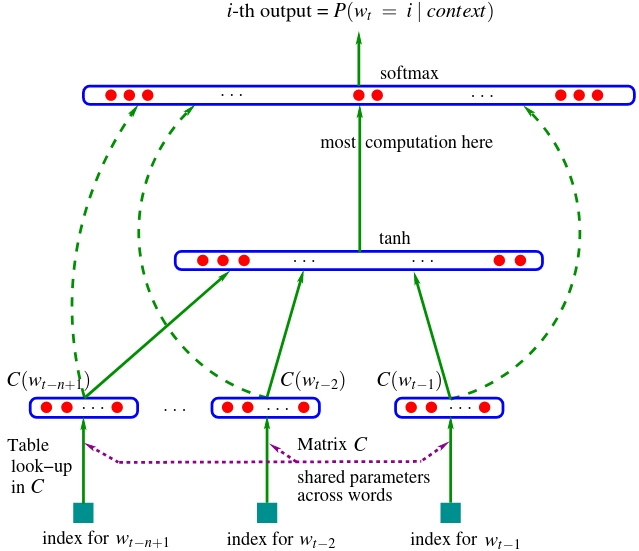

In [2]:
from IPython.display import Image, display

display(Image(filename="bengio2003nn.jpeg"))

and we have been implementing this over the last few lessons. Now, I'm sure everyone is very excited to go into recurrent neural networks (**rnn**s) and all of their variants and how they work and their diagrams look cool:

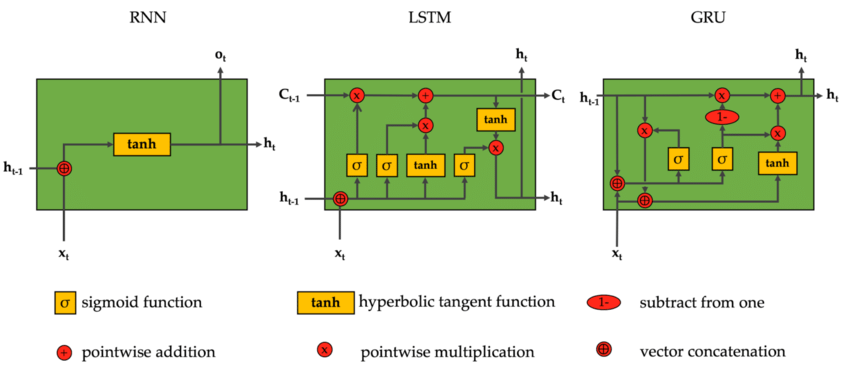

In [3]:
from IPython.display import Image, display

display(Image(filename="rnns.png"))

and such models are very exciting and interesting, and we're going to get a better result. But unfortunately, I think we have to remain here for one more lecture. And the reason for that is we've already trained this **mlp** and we are getting pretty good loss and we have developed a pretty decent understanding of the architecture and how it works. But in `train()`, we are using `loss.backward()`, a line of code that we should take an issue with if we want to have a holistic and intuitive understanding of how gradients are actually being calculated and what exactly is going on here. That is, we have been using PyTorch's autograd and using it to calculate all of our gradients along the way. Here, what we will do is remove the use of `loss.backward()`, and we will write our backward pass *manually*, at the level of tensors.

## **Backprop** back in the day

This will prove to be a very useful exercise for the following reasons. Andrej has actually an entire blogpost on this topic: [Yes you should understand **backprop**](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b), where he basically characterizes **backprop** as a leaky abstraction. And what I mean by that is that **backprop** doesn't just make your **nn**s just work *magically*. It's not the case that you can just stack up arbitrary lego blocks of differentiable functions and just cross your fingers, do *backprop* and everything is great. Things don't just work automatically. It is a leaky abstraction in the sense that you can shoot yourself in the foot if you do not understand its internals. It may magically not work or not work optimally. And you will need to understand how it works under the hood if you're hoping to debug an issue with it and if you are hoping to address it in your **nn**. So [the blog post](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b) goes into some of those examples. So for example, we've already covered some of them already. For example, the flat tails of functions such as the $sigmoid$ or $tanh$ and how you do not want to saturate them too much because your gradients will die:

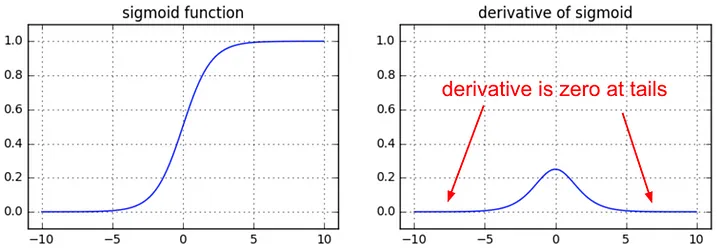

In [4]:
from IPython.display import Image, display

display(Image(filename="sigmoid_derivative.jpeg"))

There's the case of dead neurons, which we've already covered as well:

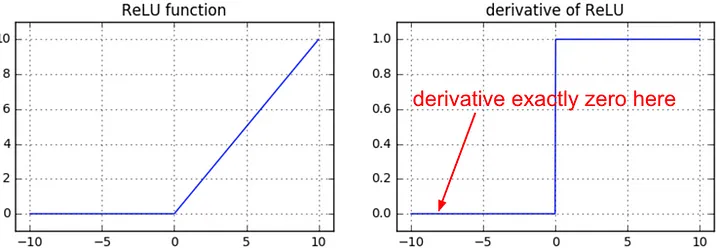

In [5]:
from IPython.display import Image, display

display(Image(filename="relu_derivative.jpeg"))

Also, the case of exploding or vanishing gradients in the case of **rnn**s, which we are about to cover:

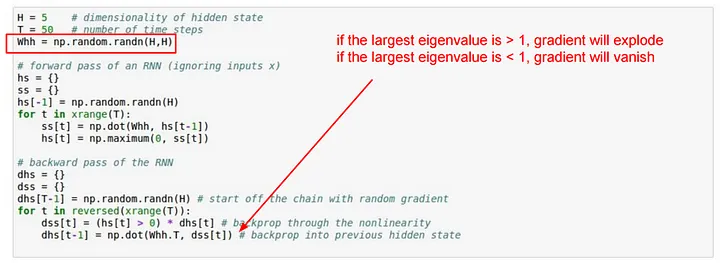

In [6]:
from IPython.display import Image, display

display(Image(filename="rnngradients.jpeg"))

And then also you will often come across some examples in the wild:

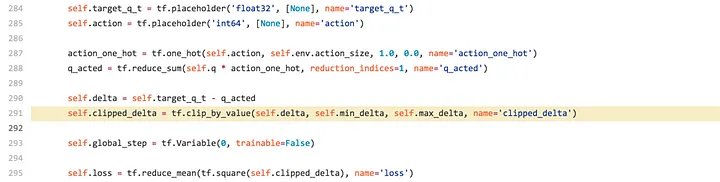

In [7]:
from IPython.display import Image, display

display(Image(filename="dqnbadclipping.jpeg"))

This is a snippet that Andrej found in a random code base on the internet where they actually have like a very subtle but pretty-major bug in their implementation. And the bug points at the fact that the author of this code does not actually understand **backprop**. So what they're trying to do here is they're trying to clip the **loss** at a certain maximum value. But actually what they're trying to do is they're trying to clip the gradients to have a maximum value instead of trying to clip the **loss** at a maximum value. And indirectly, they're basically causing some of the outliers to be actually ignored. Because, when you clip the **loss** of an outlier, you are setting its gradient to $0$. And so have a look through this and read through it. But there's basically a bunch of subtle issues that you're going to avoid if you actually know what you're doing. And that's why I don't think it's the case that because PyTorch or other frameworks offer autograd, it is okay for us to ignore how it works. Now, we've actually already covered autograd and we wrote [**micrograd**](#1.-micrograd). But [**micrograd**](#1.-micrograd) was an autograd engine only at the level of individual scalars. So the atoms were single individual numbers which I don't think is enough. And I'd like us to basically think about **backprop** at the level of tensors as well. And so in a summary, I think it's a good exercise. I think it is very, very valuable. You're going to become better at debugging **nn**s and making sure that you understand what you're doing. It is going to make everything fully explicit. So you're not going to be nervous about what is hidden away from you. Basically, we're going to emerge stronger! So let's get into it. A bit of a fun historical note here is that today, manually writing your backward pass by hand is not recommended and no one does it, except for the purposes of exercise and education. But about around $10$+ years ago in deep learning, this was fairly standard and in fact pervasive.

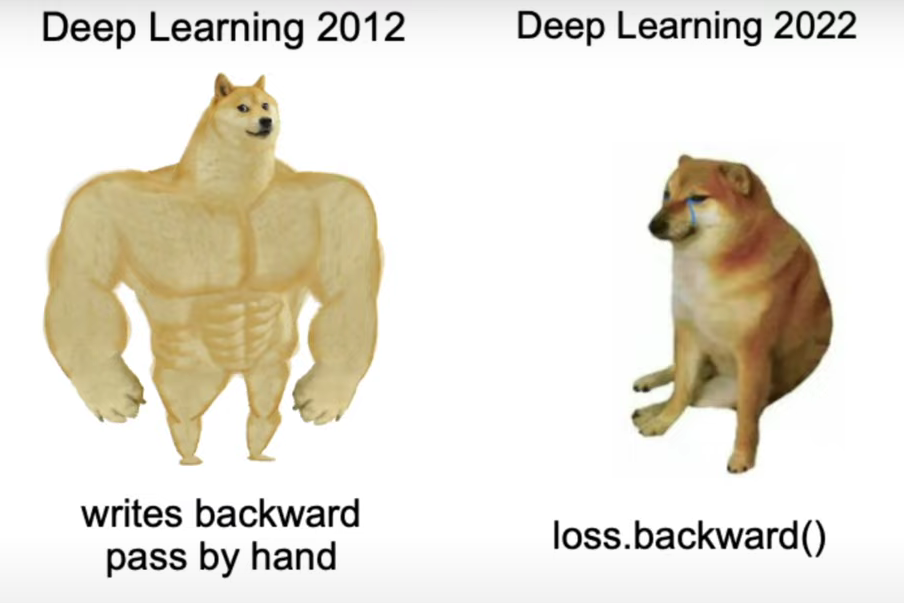

In [8]:
from IPython.display import Image, display

display(Image(filename="backwardmemelol.png"))

So at the time, everyone (including Andrej himself) used to write their backward pass manually, by hand. Now, it's our turn too! Now of course everyone just calls `loss.backward()`. But, we've lost something. I want to give you a few examples of this. So,  here's a $2006$ paper from Geoffrey Hinton and Ruslan Salakhutdinov in Science that was influential at the time: [Reducing the Dimensionality of Data with Neural Networks](https://www.cs.toronto.edu/~hinton/absps/science.pdf). And this was training some architectures called restricted Boltzmann machines (**rbm**s). And basically, it's an autoencoder trained here:

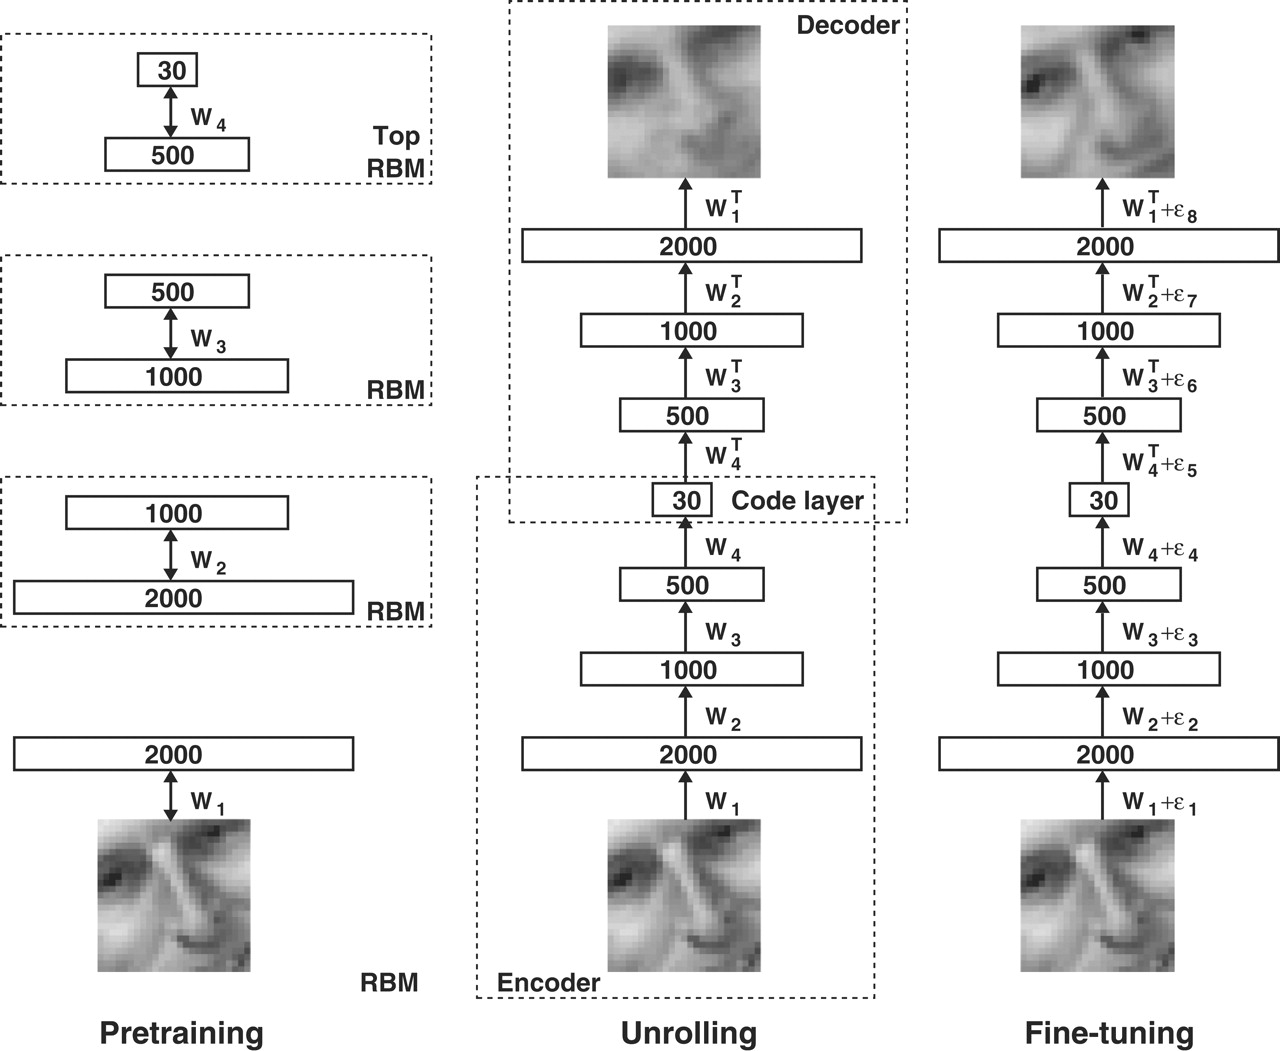

In [9]:
from IPython.display import Image, display

display(Image(filename="rbms.jpeg"))

And this is from roughly $2010$, when Andrej had written a MATLAB library for training (**rbm**s) called [matrbm](https://code.google.com/archive/p/matrbm/). And this was at the time when Python was not used for deep learning as pervasively as it is now. It was all MATLAB, which was this scientific computing package that everyone would use:

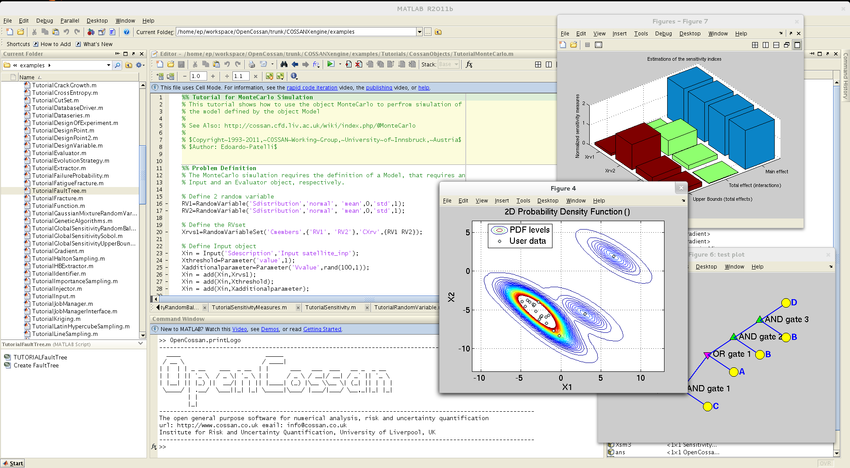

In [10]:
from IPython.display import Image, display

display(Image(filename="matlab.png"))

So we would write MATLAB, which is barely a programming language as well. But it had a very convenient tensor class. And it was this computing environment and you would run here. It would all run on the CPU, of course. But you would have very nice plots to go with it and a built-in debugger. And it was pretty decent. Now, the code in the $2010$ [matrbm](https://code.google.com/archive/p/matrbm/) package that written for fitting **rbm**s to a large extent is recognizable. Let's open up the [`rbmFit.m` source code file](https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/matrbm/RBMLIB.zip) and see if we can get a rough idea of what is going on. Well first Andrej creates the data and the x, y batches:

```MATLAB
...
%Create targets: 1-of-k encodings for each discrete label
u= unique(y);
targets= zeros(N, nclasses);
for i=1:length(u)
    targets(y==u(i),i)=1;
end

%Create batches
numbatches= ceil(N/batchsize);
groups= repmat(1:numbatches, 1, batchsize);
groups= groups(1:N);
groups = groups(randperm(N));
for i=1:numbatches
    batchdata{i}= X(groups==i,:);
    batchtargets{i}= targets(groups==i,:);
end
...
```

He's initializing the **nn** so that it's got weights as and biases just like we're used to:

```MATLAB
...
%fit RBM
numcases=N;
numdims=d;
numclasses= length(u);
W = 0.1*randn(numdims,numhid);
c = zeros(1,numdims);
b = zeros(1,numhid);
Wc = 0.1*randn(numclasses,numhid);
cc = zeros(1,numclasses);
ph = zeros(numcases,numhid);
nh = zeros(numcases,numhid);
phstates = zeros(numcases,numhid);
nhstates = zeros(numcases,numhid);
negdata = zeros(numcases,numdims);
negdatastates = zeros(numcases,numdims);
Winc  = zeros(numdims,numhid);
binc = zeros(1,numhid);
cinc = zeros(1,numdims);
Wcinc = zeros(numclasses,numhid);
ccinc = zeros(1,numclasses);
Wavg = W;
bavg = b;
cavg = c;
Wcavg = Wc;
ccavg = cc;
t = 1;
errors=zeros(1,maxepoch);
...
```

And then this is the training loop where we actually do the forward pass:

```MATLAB
...
for epoch = 1:maxepoch
    
	errsum=0;
    if (anneal)
        penalty= oldpenalty - 0.9*epoch/maxepoch*oldpenalty;
    end
    
    for batch = 1:numbatches
		[numcases numdims]=size(batchdata{batch});
		data = batchdata{batch};
		classes = batchtargets{batch};
        
        %go up
        ph = logistic(data*W + classes*Wc + repmat(b,numcases,1));
		phstates = ph > rand(numcases,numhid);
        if (isequal(method,'SML'))
            if (epoch == 1 && batch == 1)
                nhstates = phstates;
            end
        elseif (isequal(method,'CD'))
            nhstates = phstates;
        end
...
```

And then here, at this time, they didn't even necessarily use back propagation to train **nn**s. So this, in particular, implements a lot of the training that we're doing. It implements contrastive divergence, which estimates a gradient:

```MATLAB
...
        %go down
		negdata = logistic(nhstates*W' + repmat(c,numcases,1));
		negdatastates = negdata > rand(numcases,numdims);
		negclasses = softmaxPmtk(nhstates*Wc' + repmat(cc,numcases,1));
		negclassesstates = softmax_sample(negclasses);
		
        %go up one more time
		nh = logistic(negdatastates*W + negclassesstates*Wc + ... 
            repmat(b,numcases,1));
		nhstates = nh > rand(numcases,numhid);
...
```

And then here, we take that gradient and use it for a parameter update along the lines that we're used to:

```MATLAB
...
        %update weights and biases
        dW = (data'*ph - negdatastates'*nh);
        dc = sum(data) - sum(negdatastates);
        db = sum(ph) - sum(nh);
        dWc = (classes'*ph - negclassesstates'*nh);
        dcc = sum(classes) - sum(negclassesstates);
		Winc = momentum*Winc + eta*(dW/numcases - penalty*W);
		binc = momentum*binc + eta*(db/numcases);
		cinc = momentum*cinc + eta*(dc/numcases);
		Wcinc = momentum*Wcinc + eta*(dWc/numcases - penalty*Wc);
		ccinc = momentum*ccinc + eta*(dcc/numcases);
		W = W + Winc;
		b = b + binc;
		c = c + cinc;
		Wc = Wc + Wcinc;
		cc = cc + ccinc;
		
        if (epoch > avgstart)
            %apply averaging
			Wavg = Wavg - (1/t)*(Wavg - W);
			cavg = cavg - (1/t)*(cavg - c);
			bavg = bavg - (1/t)*(bavg - b);
			Wcavg = Wcavg - (1/t)*(Wcavg - Wc);
			ccavg = ccavg - (1/t)*(ccavg - cc);
			t = t+1;
		else
			Wavg = W;
			bavg = b;
			cavg = c;
			Wcavg = Wc;
			ccavg = cc;
        end
        
        %accumulate reconstruction error
        err= sum(sum( (data-negdata).^2 ));
        errsum = err + errsum;
    end
...
```

But you can see that basically people are meddling with these gradients directly and inline all by themselves. It wasn't that common to use an autograd engine. Here's one more example from Andrej's paper from $2014$ called [Deep Fragment Embeddings for Bidirectional Image Sentence Mapping](https://arxiv.org/abs/1406.5679). Here, what he was doing is he was aligning images and text:

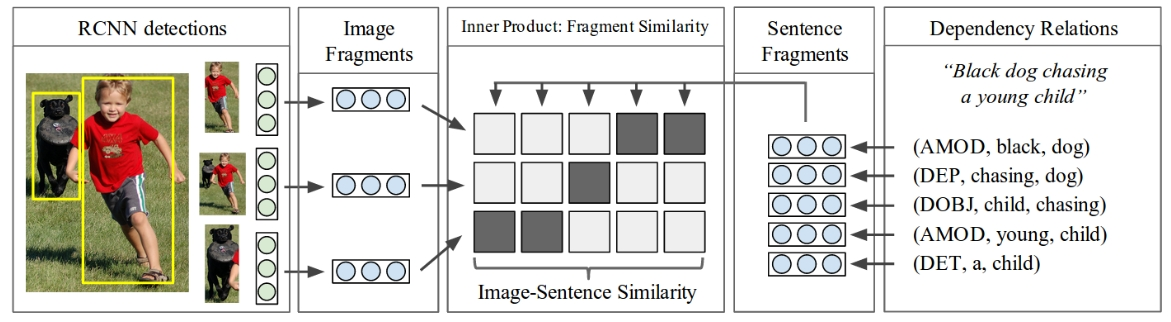

In [11]:
from IPython.display import Image, display

display(Image(filename="karpathy2014fig2.jpeg"))

And so it's kind of like a clip if you're familiar with it, but instead of working at the level of entire images and entire sentences, he was working on the level of individual objects and little pieces of sentences and he was embedding them calculating a clip-like **loss**: the cost. Back in 2014, it was standard to implement not just the cost, but also the backward pass manually. Take a look at the `DeFragCost` function from [the paper's source code](https://cs.stanford.edu/people/karpathy/defrag/code.zip):

```MATLAB
function [cost_struct, grad, df_CNN] = DeFragCost(theta,decodeInfo,params, oWe,imgFeats,depTrees, rcnn_model)
% returns cost, gradient, and gradient wrt image vectors which
% can be forwarded to the CNN for finetuning outside of this

domil = getparam(params, 'domil', false);
useglobal = getparam(params, 'useglobal', true);
uselocal = getparam(params, 'uselocal', true);
gmargin = params.gmargin;
lmargin = params.lmargin;
gscale = params.gscale;
lscale = params.lscale;
thrglobalscore = params.thrglobalscore;
smoothnum = params.smoothnum;
maxaccum = params.maxaccum;

finetuneCNN = false;
df_CNN = 0;

% unpack parameters
[Wi2s, Wsem] = stack2param(theta, decodeInfo);
cost = 0;

N = length(depTrees); % number of samples

% forward prop all image fragments and arrange them into a single large matrix
imgVecsCell = cell(1, N);
imgVecICell = cell(1, N);
if finetuneCNN
    % forward RCNN
    imgVecs = andrej_forwardRCNN(imgFeats, rcnn_model, params);
    for i=1:N
        imgVecICell{i} = ones(size(imgFeats{i}.codes,1), 1)*i;
    end
else
    for i=1:N        
        imgVecsCell{i} = imgFeats{i}.codes;
    end
    imgVecs = cat(1, imgVecsCell{:});
    for i=1:N
        imgVecICell{i} = ones(size(imgVecsCell{i},1), 1)*i;
    end
end
imgVecI = cat(1, imgVecICell{:});
allImgVecs = Wi2s * imgVecs'; % the mapped vectors are now columns
Ni = size(allImgVecs,2);

% forward prop all sentences and arrange them
sentVecsCell = cell(1, N);
sentTriplesCell = cell(1, N);
sentVecICell = cell(1, N);
for i = 1:N
    [z, ts] = ForwardSent(depTrees{i},params,oWe,Wsem);
    sentVecsCell{i} = z;
    sentTriplesCell{i} = ts;
    sentVecICell{i} = ones(size(z,2), 1)*i;
end
sentVecI = cat(1, sentVecICell{:});
allSentVecs = cat(2, sentVecsCell{:});
Ns = size(allSentVecs, 2);

% compute fragment scores
dots = allImgVecs' * allSentVecs;

% compute local objective
if uselocal

    MEQ = bsxfun(@eq, imgVecI, sentVecI'); % indicator array for what should be high and low
    Y = -ones(size(MEQ));
    Y(MEQ) = 1;

    if domil

        % miSVM formulation: we are minimizing over Y in the objective,
        % what follows is a heuristic for it mentioned in miSVM paper.
        fpos = dots .* MEQ - 9999  * (~MEQ); % simplifies things
        Ypos = sign(fpos);

        ixbad = find(~any(Ypos==1,1));
        if ~isempty(ixbad)
            [~, fmaxi] = max(fpos(:,ixbad), [], 1);
            Ypos = Ypos + sparse(fmaxi, ixbad, 2, Ni, Ns); % flip from -1 to 1: add 2
        end

        Y(MEQ) = Ypos(MEQ); % augment Y in positive bags
    end

    % weighted fragment alignment objective
    marg = max(0, lmargin - Y .* dots); % compute margins
    W = zeros(Ni, Ns);
    for i=1:Ns
        ypos = Y(:,i)==1;
        yneg = Y(:,i)==-1;
        W(ypos, i) = 1/sum(ypos);
        W(yneg, i) = 1/(sum(yneg));
    end
    wmarg = W .* marg;
    lcost = lscale * sum(wmarg(:));
    cost = cost + lcost;
end

% compute global objective
if useglobal
    
    % forward scores in all regions
    SG = zeros(N,N);
    SGN = zeros(N,N); % the number of values (for mean)
    accumsis = cell(N,N);
    for i=1:N
        for j=1:N
            d = dots(imgVecI == i, sentVecI == j);
            if thrglobalscore, d(d<0) = 0; end
            if maxaccum
                [sv, si] = max(d, [], 1); % score will be max (i.e. we're finding support of each fragment in image)
                accumsis{i,j} = si; % remember switches for backprop
                s = sum(sv);
            else
                s = sum(d(:)); % score is sum
            end
            nnorm = size(d,2); % number of sent fragments
            nnorm = nnorm + smoothnum;
            s = s/nnorm;
            SG(i,j) = s;
            SGN(i,j) = nnorm;
        end
    end
    
    % compute the cost
    gcost = 0;
    cdiffs = zeros(N,N);
    rdiffs = zeros(N,N);
    for i=1:N
        % i is the pivot. It should have higher score than col and row
        
        % col term
        cdiff = max(0, SG(:,i) - SG(i,i) + gmargin);
        cdiff(i) = 0; % nvm score with self
        cdiffs(:, i) = cdiff; % useful in backprop
        
        % row term
        rdiff = max(0, SG(i,:) - SG(i,i) + gmargin);
        rdiff(i) = 0;
        rdiffs(i, :) = rdiff; % useful in backprop
        
        gcost = gcost + sum(cdiff) + sum(rdiff);
    end
    
    gcost = gscale * gcost;
    cost = cost + gcost;
end

ltop = zeros(Ni, Ns);

if uselocal
    % backprop local objective
    ltop = ltop - lscale * (marg > 0) .* Y .* W;
end

if useglobal
    % backprop global objective
    
    % backprop margin
    dsg = zeros(N,N);
    for i=1:N
        cd = cdiffs(:,i);
        rd = rdiffs(i,:);
        
        % col term backprop
        dsg(i,i) = dsg(i,i) - sum(cd > 0);
        dsg(:,i) = dsg(:,i) + (cd > 0);
        
        % row term backprop
        dsg(i,i) = dsg(i,i) - sum(rd > 0);
        dsg(i,:) = dsg(i,:) + (rd > 0);
    end
    
    % backprop into scores
    ltopg = zeros(size(ltop));
    for i=1:N
        for j=1:N
            
            % backprop through the accumulation function
            if maxaccum
                % route the gradient along in each column. bit messy...
                gradroute = dsg(i,j) / SGN(i,j);
                mji = find(sentVecI == j);
                mii = find(imgVecI == i);
                accumsi = accumsis{i,j};
                for q=1:length(mji)
                    miy = mii(accumsi(q));
                    mix = mji(q);
                    if thrglobalscore
                        if dots(miy,mix) > 0
                            ltopg(miy, mix) = gradroute;
                        end
                    else
                        ltopg(miy, mix) = gradroute;
                    end
                end
            else
                d = dots(imgVecI == i, sentVecI == j);
                dd = ones(size(d)) * dsg(i,j) / SGN(i,j);
                if thrglobalscore
                    dd(d<0) = 0;
                end
                ltopg(imgVecI == i, sentVecI == j) = dd;
            end
        end
    end
    ltop = ltop + gscale * ltopg;
end

% backprop into fragment vectors
allDeltasImg = allSentVecs * ltop';
allDeltasSent = allImgVecs * ltop;

% backprop image mapping
df_Wi2s = allDeltasImg * imgVecs;

if finetuneCNN
    % derivative wrt CNN data so that we can pass on gradient to RCNN
    df_CNN = allDeltasImg' * Wi2s;
end

% backprop sentence mapping
df_Wsem = BackwardSents(depTrees,params,oWe,Wsem,sentVecsCell,allDeltasSent);

cost_struct = struct();
cost_struct.raw_cost = cost;
cost_struct.reg_cost = params.regC/2 * sum(theta.^2);
cost_struct.cost = cost_struct.raw_cost + cost_struct.reg_cost;

%[grad,~] = param2stack(df_Wi2s, df_Wsem);
grad = [df_Wi2s(:); df_Wsem(:);]; % for speed hardcode param2stack
grad = grad + params.regC * theta; % regularization term gradient
end
````

Around $2014$ it was standard to implement not just the cost but also the backward pass manually. So there he calculates the image embeddings sentence embeddings, sentence embeddings, the scores and the loss function. And after the loss function is calculated, he backwards through the **nn** and he appends a regularization term. So everything was done by hand manually, and you would just write out the backward pass. And then you would use a gradient checker to make sure that your numerical estimate of the gradient agrees with the one you calculated during **backprop**. This was very standard for a long time. Today, of course, it is standard to use an autograd engine. But it was definitely useful, and I think people sort of understood how these **nn**s work on a very intuitive level. Therefore, it's still a good exercise.

## Manually implementing a backward pass

Okay, so just as a reminder that we're going to keep everything the same from our previous lecture. So we're still going to have a two-layer multi-layer perceptron with a **batchnorm** layer. So the forward pass will be basically identical to this lecture. But here, we're going to get rid of `loss.backward()`. And instead, we're going to write the backward pass manually. Apart from that, we're going to keep everything the same. So the forward pass will be basically identical to the previous lesson, etc. We are simply just going to write the backward pass manually. Here's the starter code for this lecture:

In [12]:
import random
random.seed(42)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
if IN_COLAB:
    %matplotlib inline
else:
    %matplotlib ipympl
SEED = 2147483647

In [13]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [14]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
ctoi = {s: i + 1 for i, s in enumerate(chars)}
ctoi["."] = 0
itoc = {i: s for s, i in ctoi.items()}
vocab_size = len(itoc)
print(itoc)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [15]:
block_size = 3


def build_dataset(words):
    x, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = ctoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]  # crop and append
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

In [16]:
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
xtrain, ytrain = build_dataset(words[:n1])  # 80%
xval, yval = build_dataset(words[n1:n2])  # 10%
xtest, ytest = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Now, here, we'll introduce a utility function that we're going to use later to compare the gradients. So in particular, we are going to have the gradients that we estimate manually ourselves. And we're going to have gradients that PyTorch calculates. And we're going to be checking for correctness, assuming, of course, that PyTorch is correct.

In [17]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(
        f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}"
    )

Then, here, we have an initialization function that we are quite used to, where we create all the parameters:

In [18]:
def define_nn(
    n_hidden=64,
    n_embd=10,
    w1_factor=5 / 3,
    b1_factor=0.1,
    w2_factor=0.1,
    b2_factor=0.1,
    bngain_factor=0.1,
    bnbias_factor=0.1,
):
    global g, C, w1, b1, w2, b2, bngain, bnbias
    g = torch.Generator().manual_seed(SEED)
    C = torch.randn((vocab_size, n_embd), generator=g)
    input_size = n_embd * block_size
    output_size = vocab_size
    # Layer 1
    w1 = (
        torch.randn((input_size, n_hidden), generator=g)
        * w1_factor
        / ((input_size) ** 0.5)
    )
    b1 = (
        torch.randn(n_hidden, generator=g) * b1_factor
    )  # using b1 just for fun, it's useless because of batchnorm layer
    # Layer 2
    w2 = torch.randn(n_hidden, vocab_size, generator=g) * w2_factor
    b2 = torch.randn(vocab_size, generator=g) * b2_factor
    # BatchNorm parameters
    bngain = torch.ones((1, n_hidden)) * bngain_factor + 1.0
    bnbias = torch.zeros((1, n_hidden)) * bnbias_factor
    # Note: We are initializating many of these parameters in non-standard ways
    # because sometimes initializating with e.g. all zeros could mask an incorrect
    # implementation of the backward pass.
    parameters = [C, w1, b1, w2, b2, bngain, bnbias]
    print(sum(p.nelement() for p in parameters))
    for p in parameters:
        p.requires_grad = True
    return parameters

Now, you will note that we changed the initialization a little bit to be small numbers. So normally you would set the biases to be all $0$. Here, I'm setting them to be small random numbers. And I'm doing this because if your variables are all $0$, or initialized to exactly $0$, sometimes what can happen is that can mask an incorrect implementation of a gradient. Because when everything is $0$, it sort of like simplifies and gives you a much simpler expression of the gradient than you would otherwise get. And so by making it small numbers, we are trying to unmask those potential errors in these calculations. You might also notice that we are using `b1` in the first layer. We are using a bias despite **batchnorm** right afterwards. So this would typically not be what you'd do as we talked about the fact that you don't need a bias. But we are doing this here just for fun, because we are going to have a gradient **w.r.t.** it and we can check that we are still calculating it correctly even though this bias is spurious.

In [19]:
batch_size = 32


def construct_minibatch():
    ix = torch.randint(0, xtrain.shape[0], (batch_size,), generator=g)
    xb, yb = xtrain[ix], ytrain[ix]
    return xb, yb

So this function calculates a single batch. Then we will define a forward pass function:

In [20]:
def forward(xb, yb):
    emb = C[xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    # Linear layer 1
    hprebn = embcat @ w1 + b1  # hidden layer pre-activation
    # BatchNorm layer
    bnmeani = 1 / batch_size * hprebn.sum(0, keepdim=True)
    bndiff = hprebn - bnmeani
    bndiff2 = bndiff**2
    bnvar = (
        1 / (batch_size - 1) * (bndiff2).sum(0, keepdim=True)
    )  # note: Bessel's correction (dividing by n-1, not n)
    bnvar_inv = (bnvar + 1e-5) ** -0.5
    bnraw = bndiff * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # Non-linearity
    h = torch.tanh(hpreact)
    # Linear layer 2
    logits = h @ w2 + b2  # output layer
    # cross entropy loss (same as F.cross_entropy(logits, Yb))
    logit_maxes = logits.max(1, keepdim=True).values
    norm_logits = logits - logit_maxes  # subtract max for numerical stability
    counts = norm_logits.exp()
    counts_sum = counts.sum(1, keepdims=True)
    counts_sum_inv = counts_sum**-1
    probs = counts * counts_sum_inv
    logprobs = probs.log()
    globals().update(locals())  # make variables defined so far globally-accessible
    loss = -logprobs[range(batch_size), yb].mean()
    intermediate_values = [
        logprobs,
        probs,
        counts,
        counts_sum,
        counts_sum_inv,
        norm_logits,
        logit_maxes,
        logits,
        h,
        hpreact,
        bnraw,
        bnvar_inv,
        bnvar,
        bndiff2,
        bndiff,
        hprebn,
        bnmeani,
        embcat,
        emb,
    ]
    return intermediate_values, loss

In [21]:
def backward(parameters, fp_intermed_values, loss):
    # PyTorch backward pass
    for p in parameters:
        p.grad = None
    for t in fp_intermed_values:
        t.retain_grad()
    loss.backward()

This `forward()` is now significantly expanded compared to what we are used to. The reason our forward pass is longer is for two reasons. Number one, before we just had an `f.cross_entropy()`, but here we are bringing back an explicit implementation of the **loss** function. And number two, we have broken up the implementation into manageable chunks, so we have a lot more intermediate tensors along the way in the forward pass. And that's because we are about to go backwards and calculate the gradients in this **backprop**, from the bottom (`loss`) to the top (..., `emb`, `C`, `xb`). So we're going to go upwards and just like we have for example the `logprobs` in this forward pass, in the backward pass we are going to have a `dlogprobs` which is going to store the derivative of the **loss** **w.r.t.** the `logprobs` tensor ($\dfrac{\partial **loss**}{\partial logprobs}$). And so in our manual implementation of **backprop**, we are going to be prepending `d` to every one of these tensors and calculating it along the way of this **backprop**. As an example, we have  a `bnraw` here, so we're going to be calculating a `dbnraw` ($\dfrac{\partial **loss**}{\partial bnraw}$). Also, in the `backward()` function, before the `loss.backward()` call, we are calling `t.retain_grad()` and thus telling PyTorch that we want to retain the graph of all of these intermediate values. This is because:
- in **exercise 1** (coming up) we are going to calculate the backward pass, so we're going to calculate all these `d` variables and use the `cmp` function we've introduced above to check our correctness **w.r.t.** what PyTorch is telling us. This is going to be exercise 1, where we will **backprop** through this entire graph (starting from the `loss` and going upward through the intermediate values). Then,
- in **exercise 2** we will fully break up the **loss** and **backprop** through it manually in all the little atomic pieces that make it up. But then we're going to collapse the **loss** into a single cross entropy call and instead we're going to analytically derive using math and paper and pencil the gradient of the **loss** **w.r.t.** the logits and instead of **backprop**ing through all of its little chunks, one at a time, we're just going to analytically derive what that gradient is and we're going to implement that, which is much more efficient as we'll see in a bit. Next,
- for **exercise 3** we're going to do the exact same thing for **batchnorm**. We're going to use pen and paper and calculus to derive the gradient through the **batchnorm** layer. So we're going to calculate the backward pass through the **batchnorm** layer in a much more efficient expression, instead of **backprop** through all of its little pieces independently. And then,
- in **exercise 4** we're going to put it all together and this is the full code of training this two layer mlp and we're going to basically insert our manual **backprop** and we're going to take out `loss.backward()` and you will basically see that we can get all the same results using fully our own code and the only thing we're going to be using from PyTorch is `torch.tensor` to make the calculations efficient. But otherwise, you will understand fully what it means to forward and backward through the **nn** and train it and I think that'll be awesome so let's get to it.

Okay, let's now define our **nn** and do one forward and one backward pass on it:

In [22]:
parameters = define_nn()
xb, yb = construct_minibatch()
fp_intermed_values, loss = forward(xb, yb)
backward(parameters, fp_intermed_values, loss)

4137


## Exercise 1: implementing the backward pass

Now, **exercise 1**: implementing the backward pass:

We'll start with `dlogprobs`, which basically means we are going to start with calculating the gradient of the **loss** **w.r.t.** all the elements of `logprobs` tensor: $\dfrac{\partial \textbf{loss}}{\partial \textbf{logprobs}}$. So, `dlogprobs` will have the same shape as `logprobs`:

In [23]:
logprobs.shape

torch.Size([32, 27])

Now, how does `logprobs` influence the `loss`? Like this: `-logprobs[range(batch_size), yb].mean()`. Just as a reminder, `yb` is only just an array of the correct indeces:

In [24]:
yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

And so by doing `logprobs[range(batch_size), yb]`, what we are essentially doing is for each row `i` of the `logprobs` tensor (of size `batch_size`), we are plucking out the element at column index `yb[i]`. For example, from row `0` we would be getting the element from column `yb[0] == 1`, from row `1` we would be getting the element from column `yb[1] == 12`, and so on. Therefore, the elements inside the `logprobs[range(batch_size), yb]` could be alternatively calculated as such:
```python
logprobslist = [logprobs[i, yb[i]] for i in range(batch_size)]
```
Here is the proof by assertion that `logprobslist` is the same as `logprobs`:

In [25]:
logprobslist = [logprobs[i, yb[i]].item() for i in range(batch_size)]
assert logprobs[range(batch_size), yb].tolist() == logprobslist

So these elements get plucked out from `logprobs` and then the negative of their mean becomes the **loss**. It is always nice to work with simpler examples in order to understand the numerical form of derivatives. What's going on here is once we've plucked out these examples, we're taking the mean and then the negative (`-logprobs[range(batch_size), yb].mean()`). So the **loss** basically, to write it in a simpler way, is the negative of the mean of e.g. $3$ values:

```python
loss = -(a + b + c) / 3
loss = -a/3 - b/3 - c/3
```

That would be how we achieve the mean of three numbers `a`, `b`, `c` (although we actually have $32$ numbers here). But therefore the derivative of this toy **loss** **w.r.t.** `a` would basically be just:

```python
dloss/da = -1/3
```

So you can see that if we don't just have $3$ numbers (`a`, `b`, `c`), but we have $32$ numbers, then `dloss` by `dk` (where `k` is every one of those $32$ numbers) is going to be: $1/32$ or just $\frac{1}{batch\_size}$ more generally. Now, what about the other elements inside `logprobs`? Remember, `logprobs` is a large array with a `logprobs.shape` of $32 \times 27$ ($864$ numbers in total) and only:

In [26]:
logprobs[range(batch_size), yb].shape

torch.Size([32])

$32$ of these numbers participate in the **loss** calculation. So, what about the derivative of all the other $832$ numbers of the `logprobs` tensor, meaning the rest of the elements that do not get plucked out? Well, their gradient intuitively is $0$. Simply because they do not participate in the **loss** calculation. They are left out. So, since most of these numbers inside the `logprobs` tensor does not feed into the **loss**, if we were to change these numbers, then the value of `loss` wouldn't change. Which is the equivalent way of saying that the derivative of the `loss` **w.r.t.** them is zero. They don't impact it. So here's a way to implement this derivative then: we create a tensor of zeros exactly in the shape of `logprobs` and then fill in the derivative value `-1/batch_size` inside exactly these indeces: `[range(batch_size), yb]`. Therefore:

In [27]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), yb] = -1.0 / batch_size

Then this is the candidate derivative for `dlogprobs`. Let's call our assertion function to compare with the actual derivative computed by PyTorch and check whether our manually calculated derivative is correct:

In [28]:
cmp("logprobs", dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


Cool! So let's look at the definition of the `cmp` function:

```python
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')
```

What it does is that it basically receives the calculated value provided by us, which is `dt` and then checks whether it is exactly equal to `t.grad` as calculated by PyTorch. This makes sure that all of the elements are *exactly* equal. After that, it calculates for approximate equality because of floating point issues using `torch.allclose` which has a little bit of a wiggle available because sometimes you can get very, very close. But if you use a slightly different calculation, because of floating point, you can't get very, very close. Generally, because of floating point arithmetic, you can get a slightly different result. So this second call checks for an approximately equal result. And then it finds the maximum, basically the value that has the highest difference, and what is the difference, and the absolute value difference between those two. At the end it prints whether we have an exact equality, an approximate equality, and what is the largest difference. In our case, we have an exact equality. And so therefore, of course, we also have an approximate equality, and the maximum difference is exactly zero. So basically, our `dlogprobs` is exactly equal to what PyTorch calculated to be `logprobs.grad` in its backpropagation. So far, we're doing pretty well. Okay, so let's now continue our manual **backprop**. We know that `logprobs` depends on `probs` through a `.log()` call. So a `log` is applied to all the elements of `probs`, element-wise. Now, if we want `dprobs`: $\dfrac{\partial loss}{\partial probs} = \dfrac{\partial loss}{\partial logprobs}\cdot\dfrac{\partial logprobs}{\partial probs}$, then, well let's [ask WolframAlpha what the derivative of `log(x)` is w.r.t. `x`](https://www.wolframalpha.com/input?i=d%2Fdx+log%28x%29): $\dfrac{d(log(x))}{dx} = \dfrac{1}{x}$. Therefore we write out the derivative and because we are doing **backprop** and thus applying the chain rule, we want to chain it to the previous result:

In [29]:
dprobs = (1.0 / probs) * dlogprobs
cmp("probs", dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


Now, notice what happens if your `probs` is very very close to $1.0$, that means that the **nn** is predicting the character correctly, then `dprobs = (1.0 / 1.0) * dlogprobs = dlogprobs` and thus `dlogprobs` just gets passed through. But if `probs` are very low, then the fraction part that is multiplied by `dlogprobs` will be boosted instead of `dlogprobs`. So what this line is doing intuitively is it is boosting the the gradient of the examples that have a very low probability currently assigned. Next up is `counts_sum_inv`. So we want `dcounts_sum_inv` ($\dfrac{\partial loss}{\partial counts\_sum\_inv}$). But let's just pause for a moment and explain what is happening until the calculation of `counts_sum_inv`, in case all this is a bit confusing:

```python
...
# Linear layer 2
logits = h @ w2 + b2  # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
...
```

We have the `logits` that come out of the **nn**. Then we are finding the maximum in each row that we then subtract from the `logits` for purposes of numerical stability. Then, because some of the logits may take on too large values we end up exponentiating (this is done just for safety, numerically). This exponentiation yields our `counts`. And then, we take the sum of these `counts`. Using this `counts_sum`, we normalize the `counts` so that all of the `probs` sum to $1$. But basically, all that's happening here is we got the logits, we want to exponentiate all of them, and we want to normalize the counts to create our probabilities, it's just that we have defined this set of intermediate calculations across multiple lines. Ok, so what should be `dcounts_sum_inv`? Now, we actually have to be careful here because we have to scrutinize and be careful with the shapes. So, `counts.shape` and `counts_sum_inv.shape` are different:

In [30]:
print(counts.shape, counts_sum_inv.shape)
assert counts.shape != counts_sum_inv.shape

torch.Size([32, 27]) torch.Size([32, 1])


So during the multiplication `probs = counts * counts_sum_inv`, there is an implicit broadcasting that PyTorch does. Because what it needs to do is take one column of $32 \times 1$ that is `counts_sum_inv` and replicate it horizontally $27$ times in order to align these two tensors so it can do an element-wise multiplication. Using a toy example, this is what this looks like:

In [31]:
# c = a * b, but with tensors:
# a[3x3] * b[3,1] --->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# c[3x3]

In this example, in order for $a[3\times3]$ to multiply $b[3\times1]$, we have to replicate $3$ times the vertical column $[b1, b2, b3]^T$ horizontally. And then do the actual multiplication. And this is exactly what PyTorch does in this situation. Meaning, in order to do $c = a \cdot b$ ($c[3\times3] = a[3\times3] \cdot b[3\times1]$) it:
1. first replicates $b$ across the column dimension ($1$): $b \rightarrow b\_replicated$ ($b[3\times1] \rightarrow b[3\times3]$)
2. then it does the multiplication $c = a \cdot b\_replicated$ ($c[3\times3] = a[3\times3] \cdot b[3\times3]$)

Therefore, if we wanted to find $\dfrac{\partial c}{\partial a}$, then that would equal be $a\_replicated$ (and **not** $a$). What the replication operation means in terms of the computational graph is that $a$ in this case is being fed to multiple outputs. Thus, as we discussed in **micrograd** (lesson 1), during the backward pass, the correct thing to do in this case is to sum all the gradients that arrive at any one node  (i.e. $a$). So if a node is used multiple times, the gradients for all of its uses sum during **backprop**. This means that since e.g. $b1$ is used multiple times in each column of $c$, therefore the right thing to do here would be to sum horizontally across all the columns:
```python
da = a_replicated = a.sum(1, keepdim=True)
```
Equivalently, `probs = counts * counts_sum_inv`, is broken up into to operations as well:
1. first, the replication: $counts\_sum\_inv \rightarrow counts\_sum\_inv\_replicated$ ($counts\_sum\_inv[32\times1] \rightarrow counts\_sum\_inv[32\times27]$)
2. then, the multiplication: $probs = counts \cdot counts\_sum\_inv\_replicated$ ($probs[32\times27] = counts[32\times27] \cdot counts\_sum\_inv[32\times27]$)

And therefore `dcounts_sum_inv` ($\dfrac{\partial loss}{\partial counts\_sum\_inv} = \dfrac{\partial loss}{\partial probs} \dfrac{\partial probs}{\partial counts\_sum\_inv}$):

In [32]:
dcounts_sum_inv = (counts * dprobs).sum(
    1, keepdim=True
)  # multiply by `dprobs` because of chain rule and keepdim=True to keep the column dimension
assert dcounts_sum_inv.shape == counts_sum_inv.shape  # shapes are equals
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


Again, this derivative is exactly correct. Let's also **backprop** into `counts`. Similarly, `dcounts` is:

In [33]:
dcounts = counts_sum_inv * dprobs
assert dcounts.shape == counts.shape

with no additional summation required here since there is a broadcasting going on that will yield a derivative with a shape that is equivalent to the shape of the `counts` tensor. But we can't call `cmp` and check the correctness of `dcounts` just yet. The reason is that besides being used to calculate `probs`, it is also being used in another branch to calculate `counts_sum_inv`. So, even though we have calculated the first contribution of it: $\dfrac{\partial loss}{\partial probs}\cdot\dfrac{\partial probs}{\partial counts}$, we still have to calculate the second contribution of it: $\dfrac{\partial loss}{\partial counts\_sum}\cdot\dfrac{\partial counts\_sum}{\partial counts}$. To continue with this branch, we now want to calculate `dcounts_sum`: $\dfrac{\partial loss}{\partial counts\_sum} = \dfrac{\partial counts\_sum\_inv}{\partial counts\_sum}\cdot\dfrac{\partial loss}{\partial counts\_sum\_inv}$. With the [help of WolframAlpha](https://www.wolframalpha.com/input?i=d%2Fdx+x**-1):

In [34]:
dcounts_sum = (-(counts_sum**-2)) * dcounts_sum_inv
cmp("counts_sum", dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


Cool. Next, moving along, we want to **backprop** through the preceding operation: `counts_sum = counts.sum(1, keepdims=True)`. This means we want to now calculate the additional `dcounts` component: $\dfrac{\partial loss}{\partial counts} = \dfrac{\partial loss}{\partial counts\_sum}\cdot\dfrac{\partial counts \_sum}{\partial counts}$. If we remember from **micrograd**, the sum operation basically acts just like a router, allowing the gradient (`dcounts_sum`, in our case) to distribute equally to all the input during the backward flow. In other words, to use a toy example:

In [35]:
# b = sum(a), but with tensors:
# b[3,1] = a[3x3].sum(1) --->
# a11 a12 a13 ---> b1 (= a11 + a12 + a13)
# a21 a22 a23 ---> b2 (= a21 + a22 + a23)
# a31 a32 a33 ---> b3 (= a31 + a32 + a33)

Therefore considering that $a$ and $b$ are multi-dimensional tensors: $\dfrac{\partial b_{3\times1}}{\partial a_{3\times3}} = \dfrac{\partial{\sum a_{3\times3}}}{\partial a_{3\times3}} = \dfrac{\partial \textbf{1}_{3\times3}^T a_{3\times3}}{\partial a_{3\times3}} = \textbf{1}_{3\times3}$. Therefore, similarly, $\dfrac{\partial counts\_sum}{\partial counts} = \textbf{1}$, where the matrix $\textbf{1}$ has the shape of `counts`. Therefore, we can now add the calculated second component $\dfrac{\partial counts\_sum}{\partial counts}\dfrac{\partial loss}{\partial counts\_sum}$ to `dcounts`. And since there is no extra component that makes up `dcounts` we can do:

In [36]:
dcounts += torch.ones_like(counts) * dcounts_sum

And now `dcounts` is equal to: $\dfrac{\partial loss}{\partial counts} = \dfrac{\partial loss}{\partial probs}\cdot\dfrac{\partial probs}{\partial counts} + \dfrac{\partial loss}{\partial counts\_sum}\cdot\dfrac{\partial counts\_sum}{\partial counts}$. And now, we can check for correctness:

In [37]:
cmp("counts", dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


Awesome! The match is exact, which of course means that once again we have correctly calculated the gradient of yet-another node, and our smooth manual **backprop**ing journey continues! So hopefully we should be getting a hang of this now. Now, `dnorm_logits` is easy:

In [38]:
dnorm_logits = counts * dcounts
cmp("norm_logits", dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


since $\dfrac{\partial loss}{\partial norm\_logits} = \dfrac{\partial counts}{\partial norm\_logits}\cdot\dfrac{\partial loss}{\partial counts} = \dfrac{\partial e^{norm\_logits}}{\partial norm\_logits}\cdot\dfrac{\partial loss}{\partial counts} = e^{norm\_logits}\cdot\dfrac{\partial loss}{\partial counts} = counts\cdot\dfrac{\partial loss}{\partial counts}$. Let's continue. Next up is `norm_logits = logits - logit_maxes`. So now we care about finding `dlogits` and `dlogit_maxes`. We have to be careful here again as the shapes are not the same:

In [39]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

This means that when the subtraction happens there is going to be an implicit broadcasting happening:

In [40]:
# c = a - b, but with tensors: a[3x3], b[3x1], c[3x3]
# c11 c12 c13 = a11 a12 a13   b1
# c21 c22 c23 = a21 a22 a23 - b2
# c31 c32 c33 = a31 a32 a33   b3

# so e.g. c32 = a32 - b3

For calculating `dlogits` we care about finding the (first) component $\dfrac{\partial norm\_logits}{\partial logits}\dfrac{\partial loss}{\partial norm\_logits} = \dfrac{\partial loss}{\partial norm\_logits}$. And therefore:

In [41]:
dlogits = dnorm_logits.clone()

Now, like for `dcounts` previously, we cannot yet check for the correctness of `dlogits` because there is still a second component that should be added to the first one to make up the complete `dlogits` gradient $\dfrac{\partial loss}{\partial logits}$. Before we calculate that let's first find `dlogit_maxes`: $\dfrac{\partial loss}{\partial logit\_maxes} = \dfrac{\partial norm\_logits}{\partial logit\_maxes}\dfrac{\partial loss}{\partial norm\_logits} = -\dfrac{\partial loss}{\partial norm\_logits}$, which essentially means: `dlogit_maxes = -dnorm_logits`. Now remember, because we are dealing with tensors and `logit_maxes` has a shape of $32\times1$, that means that `-dnorm_logits`, whose shape is $32\times27$, must be summed along the column axis in order for `dlogits_maxes` to become a $32\times1$ tensor (the same shape as `logit_maxes`). Therefore:

In [42]:
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
cmp("logit_maxes", dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


Next up is: `logit_maxes = logits.max(1, keepdim=True).values`. Now, this is the line out of which we will find the second derivative component of `dlogits`: $\dfrac{\partial logit\_maxes}{\partial logits}\cdot\dfrac{\partial loss}{\partial logit\_maxes}$. But what is $\dfrac{\partial logit\_maxes}{\partial logits}$ lossin this case? Before we answer this question, let's pause here briefly and look at these `logit_maxes`, and especially their gradients. We've talked previously in the previous lesson that the only reason we're doing this is for the numerical stability of the softmax that we are implementing here. And we talked about how if you take these `logits` for any one of these examples, so one row of this logits tensor, if you add or subtract any value equally to all the elements, then the value of the `probs` will be unchanged. You're not changing the softmax. The only thing that this is doing is it's making sure that the subsequent `exp()` operation doesn't overflow. And the reason we're using a `max` is because then we are guaranteed that each row of logits, the highest number, is $0$. Basically, that has repercussions. If it is the case that changing `logit_maxes` does not change the `probs`, and therefore does not change the `loss`, then the gradient on `logit_maxes` should be $0$. Are they?

In [43]:
dlogit_maxes

tensor([[-4.6566e-09],
        [-9.3132e-10],
        [-1.8626e-09],
        [-4.6566e-09],
        [-9.3132e-10],
        [-1.6298e-09],
        [-3.7253e-09],
        [-4.6566e-09],
        [-5.5879e-09],
        [-1.8626e-09],
        [ 1.3970e-09],
        [-9.3132e-10],
        [ 3.4925e-09],
        [-1.1642e-09],
        [ 2.3283e-10],
        [ 6.2864e-09],
        [ 0.0000e+00],
        [-6.9849e-10],
        [ 5.3551e-09],
        [ 1.1642e-09],
        [ 0.0000e+00],
        [-2.0955e-09],
        [ 6.7521e-09],
        [ 9.3132e-10],
        [ 1.8626e-09],
        [ 9.3132e-10],
        [-3.7253e-09],
        [-9.3132e-10],
        [ 4.6566e-09],
        [ 4.6566e-10],
        [-2.3283e-09],
        [ 3.0268e-09]], grad_fn=<SumBackward1>)

Not exactly. But regardless, these are very very tiny floating point numbers that are close to $0$. And so this is telling us that the values of `logit_maxes` are not impacting the `loss`, as they should not. It feels kind of weird to **backprop** through this branch, honestly, because if you have any implementation of `f.cross_entropy` in PyTorch, and you block together all of these elements, and you're not doing **backprop** piece by piece, then you would probably assume that the derivative through here is exactly $0$. So you would be sort of skipping this branch. Because it's only done for numerical stability. But it's interesting to see that even if you break up everything into the full atoms, and you still do the computation as you'd like **w.r.t.** numerical stability, the correct thing happens. And you still get very, very small gradients here. Basically reflecting the fact that the values of these do not matter **w.r.t.** the final **loss**. Okay, so let's now continue **backprop** through this line here. We've just calculated the `logit_maxes`, and now we want to **backprop** into `logits` through this second branch. Here we took the max along all the rows and then looked at its values `logits.max(1, keepdim=True).values`. In PyTorch, max returns both the max values but also the indices of those values:

In [44]:
logits.max(1, keepdim=True)

torch.return_types.max(
values=tensor([[1.0230],
        [0.8773],
        [1.2418],
        [0.6361],
        [1.7365],
        [0.9537],
        [0.8150],
        [1.4842],
        [1.0861],
        [1.1175],
        [1.7868],
        [2.0955],
        [1.1189],
        [0.9202],
        [0.5922],
        [0.8290],
        [0.9719],
        [0.7808],
        [1.1189],
        [0.8777],
        [0.8088],
        [1.0604],
        [1.1189],
        [1.2769],
        [1.6185],
        [1.0034],
        [1.2943],
        [1.0409],
        [1.0030],
        [0.7977],
        [1.1389],
        [0.9284]], grad_fn=<MaxBackward0>),
indices=tensor([[ 1],
        [ 2],
        [19],
        [15],
        [15],
        [25],
        [16],
        [ 3],
        [19],
        [ 8],
        [15],
        [ 3],
        [22],
        [18],
        [ 7],
        [ 5],
        [ 2],
        [ 1],
        [22],
        [19],
        [15],
        [19],
        [22],
        [22],
        [23],
        [

Although we just keep the values, in the backward pass, it is extremely useful to know about where those maximum values occured. And these indices will help us with the **backprop**. Again, we ask, what is $\dfrac{\partial logit\_maxes}{\partial logits}$ in this case? We have the `logits` whose shape is:

In [45]:
logits.shape

torch.Size([32, 27])

and in each row we find the maximum value. And then that value gets plucked out into `logit_maxes`. And so intuitively, the derivative we are looking for (that is flowing through) $1$ (for the appropriate entry that was plucked out) times `dlogit_maxes`. So if you think about it, what we want here is we need to take the `dlogit_maxes` tensor and scatter it into the correct positions in `logits`, meaning the indices of the max values. One way to do this is create a tensor with $1s$ at the indices we care about and $0s$ elsewhere and multiply this tensor by `dlogit_maxes`.

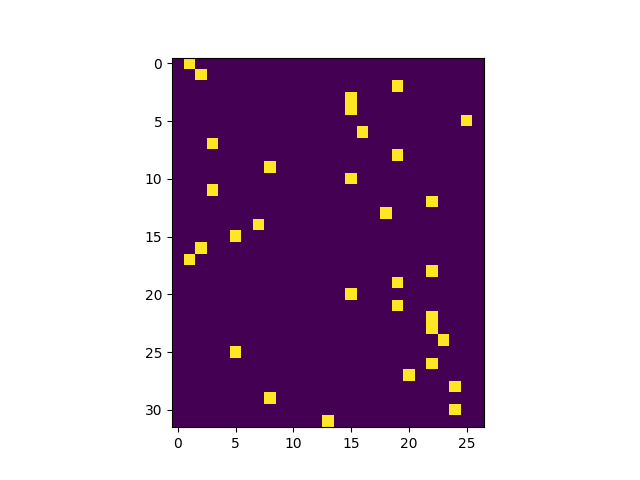

In [46]:
ones_maxes_indeces = F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])
plt.imshow(ones_maxes_indeces)
plt.show();

This is basically what we want. And array of $1s$ at one position (the index where the maxes came from) in each row of our `logits` tensor. Therefore, let's now add the second derivative component to `dlogits` and check for correctness.

In [47]:
dlogits += ones_maxes_indeces * dlogit_maxes
cmp("logits", dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


Next up: `logits = h @ w2 + b2`. Let's look at the shapes of all the intermediate tensors:

In [48]:
logits.shape, h.shape, w2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

Now let's see the shape of `h @ w2`:

In [49]:
(h @ w2).shape

torch.Size([32, 27])

This tells us that since the shape of `b2` is $27$, the `h @ w2 + b2` will first broadcast the `b2` tensor into a shape of $1\times27$ and then it will be replicated vertically along the columns (across the $0$ dimension) in order to give rise to a `b2_replicated` with a shape of $32\times27$. But the question now is how do we **backprop** from `logits` to the hidden states `h`, the weight matrix `w2` and the bias matrix `b2`? Now you might think that we need to go to some matrix calculus textbook and look up the derivative for matrix multiplication. But actually first principles suffice here to derive this yourself on a piece of paper. Specifically, what works great in these types of situations is to find a specific small example that you then fully write out and then in the process of analyzing how that individual small example works out, you will understand a broader pattern and you'll be able to generalize and write out the full general formula for how derivatives flow in an expression like this one. So let's try that out:

$d = a \cdot b + c\\
\begin{bmatrix}
d_{11} & d_{12} \\
d_{21} & d_{22}
\end{bmatrix} =
\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22}
\end{bmatrix} \cdot
\begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22}
\end{bmatrix} + 
\begin{bmatrix}
c_{1} & c_{2}
\end{bmatrix} \Rightarrow \\
d_{11} = a_{11}b_{11} + a_{12}b_{21} + c_1 \\
d_{12} = a_{11}b_{12} + a_{12}b_{22} + c_2 \\
d_{21} = a_{21}b_{11} + a_{22}b_{21} + c_1 \\
d_{22} = a_{21}b_{12} + a_{22}b_{22} + c_2
$

where
$\begin{bmatrix}
c_{1} & c_{2}
\end{bmatrix}$
gets implicitly replicated vertically into a
$\begin{bmatrix}
c_{1} & c_{2} \\
c_{1} & c_{2}
\end{bmatrix}$
in order for the addition to be a valid one. This is something that PyTorch also does. So as we know `dlogits`, by analogy, assume we also know `dd`. And since we are looking for `dh`, `dw2` and `db2`, in this simple example, by analogy, we are looking for `da`, `db`, `dc`. Let's write them out by hand:
- $
\dfrac{\partial L}{\partial a} = 
\begin{bmatrix}
\dfrac{\partial L}{\partial a_{11}} & \dfrac{\partial L}{\partial a_{12}} \\
\dfrac{\partial L}{\partial a_{21}} & \dfrac{\partial L}{\partial a_{22}}
\end{bmatrix} = 
\begin{bmatrix}
\dfrac{\partial L}{\partial d_{11}}b_{11} + \dfrac{\partial L}{\partial d_{12}}b_{12} & \dfrac{\partial L}{\partial d_{11}}b_{21} + \dfrac{\partial L}{\partial d_{12}}b_{22} \\
\dfrac{\partial L}{\partial d_{21}}b_{11} + \dfrac{\partial L}{\partial d_{22}}b_{12} & \dfrac{\partial L}{\partial d_{21}}b_{21} + \dfrac{\partial L}{\partial d_{22}}b_{12}
\end{bmatrix} =
\begin{bmatrix}
\dfrac{\partial L}{\partial d_{11}} & \dfrac{\partial L}{\partial d_{12}} \\
\dfrac{\partial L}{\partial d_{21}} & \dfrac{\partial L}{\partial d_{22}}
\end{bmatrix}
\begin{bmatrix}
b_{11} & b_{21} \\
b_{12} & b_{22}
\end{bmatrix} = 
\dfrac{\partial L}{\partial d} \cdot b^T
$

- $\dfrac{\partial L}{\partial b} =
\begin{bmatrix}
\dfrac{\partial L}{\partial b_{11}} & \dfrac{\partial L}{\partial b_{12}} \\
\dfrac{\partial L}{\partial b_{21}} & \dfrac{\partial L}{\partial b_{22}}
\end{bmatrix} =
\begin{bmatrix}
a_{11}\dfrac{\partial L}{\partial d_{11}} + a_{21}\dfrac{\partial L}{\partial d_{21}} & a_{11}\dfrac{\partial L}{\partial d_{12}} + a_{21}\dfrac{\partial L}{\partial d_{22}} \\
a_{12}\dfrac{\partial L}{\partial d_{11}} + a_{22}\dfrac{\partial L}{\partial d_{21}} & a_{12}\dfrac{\partial L}{\partial d_{12}} + a_{22}\dfrac{\partial L}{\partial d_{22}}
\end{bmatrix} = 
\begin{bmatrix}
a_{11} & a_{21} \\
a_{12} & a_{22}
\end{bmatrix} 
\begin{bmatrix}
\dfrac{\partial L}{\partial d_{11}} & \dfrac{\partial L}{\partial d_{12}} \\
\dfrac{\partial L}{\partial d_{21}} & \dfrac{\partial L}{\partial d_{22}}
\end{bmatrix} = 
a^T \cdot \dfrac{\partial L}{\partial d}$
- $\dfrac{\partial L}{\partial c} =
\begin{bmatrix}
\dfrac{\partial L}{\partial c_{1}} & \dfrac{\partial L}{\partial c_{2}}
\end{bmatrix} =
\begin{bmatrix}
\dfrac{\partial L}{\partial c_{1}} & \dfrac{\partial L}{\partial c_{2}} \\
\end{bmatrix} =
\begin{bmatrix}
1\dfrac{\partial L}{\partial d_{11}} + 1\dfrac{\partial L}{\partial d_{21}} & 1\dfrac{\partial L}{\partial d_{12}} + 1\dfrac{\partial L}{\partial d_{22}}
\end{bmatrix} =
(\dfrac{\partial L}{\partial d}).sum(0)$

After calculating these derivatives, long story short, the backward pass of a matrix multiply is a matrix multiply. Therefore, just like we had `d = a * b + c` (scalar case), so does `d = a @ b + c` (matrix case) lead us to something very very similar but now with a matrix multiplication instead of a scalar multiplication. In both cases: `da = dd @ b.T` and `db = a.T @ dd` we have matrix multiplication with both `dd` and `da` or `db` terms involved, whereas `dc` is simply a sum: `dc = dd.sum(0)`. Now here's a dirty little secret: you don't need to remember the formulas we just derived for **backprop**agating through matrix multiplication. You can **backprop** through these expressions just fine. And the reason this works is because the dimensions have to work out. Let's see an example. Consider `h @ w2 + b2`. What is `dh`? The shape of `dh` must be the same as the shape of h:

In [50]:
h.shape

torch.Size([32, 64])

And then the other piece of information we now know is that `dh` must be some kind of matrix multiplication of `dlogits` with `w2`. Let's see the shapes:

In [51]:
dlogits.shape, h.shape, w2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

So since `dlogits` is $32\times27$, `w2` is $64\times27$ and `h` is $32\times64$ there is only a single way to make the shape work out in this case. Namely, the only way to achieve `dh` with size $32\times64$ (the size of `h`) is to matrix multiply `dlogits` with the transpose of `w2` (in order to make the dimensions work out):

In [52]:
dh = dlogits @ w2.T

And it is the only way to make these to matrix multiply those two pieces to make the shapes work out. And that turns out to be the correct formula, since, by analogy, as we saw in our simple example: `da = dd @ b.T`. So there's no real need to remember these formulas. Similarly, knowing that each parameter derivative must end up with the target shape of the parameter:

In [53]:
dw2 = h.T @ dlogits  # 64x32 @ 32x27 -> 64x27
db2 = dlogits.sum(0, keepdim=True)  # 32x27 -> 27

So that's the intuitive, hacky way of findings matrix parameter derivatives. Let's check if we got `dh`, `dw2` and `db2` correct:

In [54]:
cmp("h", dh, h)
cmp("w2", dw2, w2)
cmp("b2", db2, b2)

h               | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


Exactly! Nice. We have **backprop**ed through a linear layer. Woohoo! Next up for `h = torch.tanh(hpreact)`, we already have `dh` and we now need to backpropagate through `tanh` into `hpreact`, which means we are looking for `dhpreact`. If you remember, we have already done something similar in [**micrograd**](#1.-micrograd) and we remember that [$tanh$ has a very simple derivative](https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives):

In [55]:
dhpreact = (1.0 - h**2) * dh
cmp("hpreact", dhpreact, hpreact)

hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


Here, we notice that there only an approximate (and **not** an exact) equality between the the PyTorch gradient values and our own. This can be attributed to tiny floating point imprecision or perhaps a bug that has to do with specific library versions. Since the `maxdiff` is negligible, we can ignore the slight difference and safely assume that they are indeed exactly equal and make the assignment (in order to avoid any potential accumulation of slight differences and further exact inequalities):

In [56]:
dhpreact = hpreact.grad
cmp("hpreact", dhpreact, hpreact)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


Okay, next up we have `dhpreact` and now we want to **backprop** through the `bngain`, the `bnraw` and the `bnbias` (`hpreact = bngain * bnraw + bnbias`). So here these are the **batchnorm** parameters: `bngain` and `bnbias`  that take the `bnraw` that is exact unit Gaussian and they scale it and shift it. Here, we have a multiplication (`*`), but it's worth noting that this multiply is very very different from the matrix multiply `@` (e.g. in the `logits = h @ w2 + b2` we saw previously). matrix multiply means dot products between rows and columns of the involved matrices (e.g. `h` and `w2`). Whereas, `*` is an element wise multiply so things are quite a bit simpler. Yet, still, we do have to be careful with some of the broadcasting happening in this line of code though: `hpreact = bngain * bnraw + bnbias`.

In [57]:
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

You see how `bngain` and `bnbias` are $1\times64$ but `hpreact` and `bnraw` are $32\times64$. We have to be careful with that and make sure that all the shapes work out fine and that the broadcasting is correctly **backprop**agated. Let's start with calculating `dbngain`. Using the chain rule:

In [58]:
dbngain = bnraw * dhpreact

But this is incorrect. We have to be careful, since `bngain` is of size $1\times64$, which is the size `dbngain` has to have. However, `bnraw * dhpreact` has a size of $32x64$. So the correct thing to do in this case of course is to sum across the examples/rows dimension while being careful to keep the number of dimensions the same:

In [59]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)

And now the dimensions are correct! Similarly:

In [60]:
dbnraw = bngain * dhpreact  # replication occurs automatically, no summing required
dbnbias = dhpreact.sum(0, keepdim=True)  # sum to reduce the batch size dimension

Let's check for correctness:

In [61]:
cmp("bngain", dbngain, bngain)
cmp("bnraw", dbnraw, bnraw)
cmp("bnbias", dbnbias, bnbias)

bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0


Awesome! Now we get to the **batchnorm** layer. We see how here `bngain` and `bnbias` are parameters, so the backpropagation ends. But `bnraw = bndiff * bnvar_inv` is the output of the standardization:

```python
bnmeani = 1 / batch_size * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(batch_size - 1) * (bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
```

with an equivalence to the [**batchnorm** paper](https://arxiv.org/abs/1502.03167) assignments:

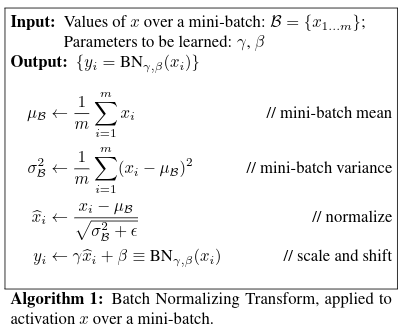

In [62]:
from IPython.display import Image, display

display(Image(filename="batchnorm_algorithm1.png"))

So, next up, on the line `bnraw = bndiff * bnvar_inv` we have to backpropagate into `bndiff` and `bnvar_inv`, having already calculated `dbnraw`. Let's see the shapes:

In [63]:
bnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

We can infer that there is broadcasting of `bnvar_inv` happening here that we have to be careful with. Other than that, this is just an element-wise multiplication. By now we should be pretty comfortable with that. Therefore:

In [64]:
dbndiff = bnvar_inv * dbnraw
# we sum since dbnvar_inv must have the same shape as `bnvar_inv`
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

Are these correct? Let's see.

In [65]:
cmp("bnvar_inv", dbnvar_inv, bnvar_inv)
cmp("bndiff", dbndiff, bndiff)

bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0
bndiff          | exact: False | approximate: False | maxdiff: 0.0011080320691689849


`dbnvar_inv` is correct. But, oh no! `dbndiff` isn't... Well, this is actually expected, because we are not yet done with `bndiff`, since it not only contributes to `bnraw` but also indirectly to `bnvar_inv` (through `bndiff2` and so on). So basically, `bndiff` branches out into two branches of which we have only **backprop**agated through one of them. So we have to continue our **backprop** until we get to the second branch of `bndiff`, where we can calculate and add the second partial derivative component to `dbndiff` using a `+=` (like we have done before for previous variables). Let's do so! Next up is: `bnvar_inv = (bnvar + 1e-5)**-0.5`. [This is just](https://www.wolframalpha.com/input?i=dx%5En%2Fdx):

In [66]:
dbnvar = (-0.5 * ((bnvar + 1e-5) ** -1.5) * 1) * dbnvar_inv
cmp("bnvar", dbnvar, bnvar)

bnvar           | exact: True  | approximate: True  | maxdiff: 0.0


which is the correct result! Now before we move on here, let's talk a bit about Bessel's correction from: `bnvar = 1/(batch_size - 1) * (bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)`. You'll notice that dividing by `n-1` instead of `n` is a departure from the paper (where `m` == `n` == `batch_size`). So it turns out that there are two ways of estimating variance of an array. One is the biased estimate, which is `1/n` and the other one is the unbiased estimate which is `1/n-1`. Now confusingly in the paper it's not very clearly described and also it's a detail that kind of matters. They essentially use the biased version at training time but later when they are talking about the inference, they are mentioning that when they do the inference they are using the unbiased estimate (which is `1/n-1` version) to calibrate the running mean and the running variance basically. And so they actually introduce a train test mismatch where in training they use the biased version and in test time they use the unbiased version. This of course is very confusing. You can read more about the Bessel's correction: https://mathcenter.oxford.emory.edu/site/math117/besselCorrection/ and why dividing by `n-1` gives you a better estimate of the variance in the case where you have population sizes or samples from a population that are very small. And that is indeed the case for us because we are dealing with mini-matches and these mini-matches are a small sample of a larger population which is the entire training set. And it turns out that if you just estimate it using `1/n` that actually almost always underestimates the variance and it is a biased estimator and it is advised that you use the unbiased version and divide by `n-1`. The documentation of [`torch.var`](https://pytorch.org/docs/stable/generated/torch.var.html) and [`torch.nn.BatchNorm1d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) are less confusing. So, long story short, since PyTorch uses Bessel's correction, we will too. Ok, so let's now **backprop** through the next line: `bnvar = 1/(batch_size - 1) * (bndiff2).sum(0, keepdim=True)`. As you might have realized until now, it is good practice to scrutinize the shapes first. 

In [67]:
bnvar.shape, bndiff2.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

Therefore the sum operation in this line is squashing the first dimension $32$ into $1$. This hints to us that will be some kind of replication or broadcasting in the backward pass. And maybe you're noticing a pattern here: everytime you have a `sum` in the forward pass, that turns into a replication or broadcasting in the backward pass along the same dimension. And conversely, when we have a replication or broadcasting in the forward pass, that indicates a variable reuse and so in the backward pass that turns into a `sum` over the exact same dimension. And so we are noticing a duality, where these two operations are kind of like the opposites of each other in the forward and the backward pass. Now, usually once we have understood the shapes, the next thing to look at is a toy example in order to roughly understand how the variable dependencies go in the mathematical formula. In the line we are interested in we have an array (`bndiff2`) on which we are summing vertically over the columns (`(bndiff2).sum(0, keepdim=True)`) and that we are scaling (by `1/(batch_size - 1)`). So if we have a $2\times2$ matrix $a$ that we then sum over the columns and then scale, we would get:

In [68]:
# a11 a12
# a21 a22
# -> 
# b1 b2, where:
# b1 = 1/(n-1)*(a11 + a21)
# b2 = 1/(n-1)*(a12 + a22)

Looking at this simple example, what we want basically is we want to **backpro** the derivative of `b`, `db1` and `db2` into all the elements of `a`. And so it's clear that, by just differentiating in your head, the local derivatives of `b` are simply `(1/(n-1))*1` for each one of these elements of `a`. Basically, each local derivative will flow through each column of `a` and be scaled by `1/(n-1)`. Therefore, intuitively:

In [69]:
# basically a large array of ones the size of bndiff2 times dbnvar (chain rule), scaled
dbndiff2 = (1 / (batch_size - 1)) * torch.ones_like(bndiff2) * dbnvar

Notice here how we are multiplying a scaled ones array of shape $32x64$ with `dbnvar`, an array of $1\times64$. Basically we are just letting PyTorch do the replication, so that we end up with a `dbndiff2` array of $32\times64$ (same size as `bndiff2`). And indeed we see that this derivative is correct:

In [70]:
cmp("bndiff2", dbndiff2, bndiff2)

bndiff2         | exact: True  | approximate: True  | maxdiff: 0.0


Next up, let's differentiate here: `bndiff2 = bndiff**2` into `bndiff`. This is a simple one, but don't forget the addition assignment, as this will now be adding the second partial derivative component to the first one we already calculated before. So this completes the backpropagation through the second branch of `bndiff`:

In [71]:
dbndiff += (2 * bndiff) * dbndiff2
cmp("bndiff", dbndiff, bndiff)

bndiff          | exact: True  | approximate: True  | maxdiff: 0.0


As you can see now, the derivative of `bndiff` is now exact and correct. That's comforting! Next up: `bndiff = hprebn - bnmeani`. Let's check the shapes:

In [72]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

Therefore, the minus sign here ($-$) is actually doing broadcasting. Let's be careful about that as this hints us to the duality we previously mentioned. A broadcasting in the forward pass means variable reuse and therefore translates to a sum operation in the backward pass. Let's find the derivatives:

In [73]:
dhprebn = 1 * dbndiff
dbnmeani = (-1 * dbndiff).sum(0, keepdim=True)
cmp("hprebn", dhprebn, hprebn)
cmp("bnmeani", dbnmeani, bnmeani)

hprebn          | exact: False | approximate: False | maxdiff: 0.001130998833104968
bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0


And `dhprebn` is wrong... Damn! Haha, well, don't sweat it. This is supposed to be wrong! Can you guess why? Like happened for `bndiff`, this is also not the only branch we have to backpropagate to for calculating `dhprebn`, since `bnmeani` also depends on `hprebn`. Therefore, there will be a second derivative component coming from this second branch. So we are not done yet. This we will find now since the next line is: `bnmeani = 1 / batch_size * hprebn.sum(0, keepdim=True)`. Now here again we have to be careful since there is a sum along dimension $0$ so this will turn into broadcasting in the backward pass. So, similarly to the `bnvar` line and the `dbndiff2` calculation:

In [74]:
dhprebn += (1.0 / batch_size) * torch.ones_like(hprebn) * dbnmeani
cmp("hprebn", dhprebn, hprebn)

hprebn          | exact: True  | approximate: True  | maxdiff: 0.0


Awesome! So that completes the **backprop** of the **batchnorm** layer. Next up we will **backprop**agate through the linear layer: `hprebn = embcat @ w1 + b1`. Like we have already mentioned, **backprop**agating through linear layers is pretty easy. So let's inspect the shapes and begin.

In [75]:
hprebn.shape, embcat.shape, w1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

Now we find `dembcat` to be $32x30$. We need to take `w1` of size $30x64$ (the tensor that is matrix-multiplied by `embcat`) and matrix-multiply it with `dhprebn` (think chain rule). Therefore, we need to do:

In [76]:
dembcat = dhprebn @ w1.T
cmp("embcat", dembcat, embcat)

embcat          | exact: True  | approximate: True  | maxdiff: 0.0


And similarly for the remaining variables:

In [77]:
dw1 = embcat.T @ dhprebn
db1 = (1 * dhprebn).sum(0)
cmp("w1", dw1, w1)
cmp("b1", db1, b1)

w1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


Cool, everything is correct! Moving onto `embcat = emb.view(emb.shape[0], -1)`:

In [78]:
embcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

As you can see, the view operation squashes the last two dimensions of the `emb` tensor (`3`, `10`) into one dimension (`30`). So here we are dealing with a concatenation of dimensions in the forward pass, therefore we want to undo that in the backward pass. We can do this again using the view operation:

In [79]:
demb = dembcat.view(emb.shape)
cmp("emb", demb, emb)

emb             | exact: True  | approximate: True  | maxdiff: 0.0


Simple, right? Now the only operation that is left to **backprop** into is the initial indexing operation: `emb = C[xb]`. Let's look at the shapes:

In [80]:
emb.shape, C.shape, xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

So what is happening in this indexing operation? `xb` ($32$ examples, $3$ character indeces per example) is being used to index the lookup table `C` ($27$ possible character indeces, $10$ embedding dimensions per character index) to yield `emb` ($32$ examples, $3$ character indeces per example, $10$ embedding dimensions per character index). In other words, by indexing `C` using `xb` we are using each integer in `xb` to specify which row of `C` we want to pluck out. This indexing operation yields an embeddings tensor `emb` of $32$ examples (same as the indexing tensor `xb`), $3$ plucked-out character rows per example (from `C`), each of which contains $10$ embedding dimesions. So now, for each one of these plucked-out rows we have their gradients `demb` (arranged in a $32\times3\times10$ tensor). All we have to do now is to route this gradients backwards through this indexing operation. So first we need to find the specific rows of `C` that every one of these $10$-dimensional embeddings comes from. And then, into the corresponding `dC` row indices we need to deposit the `demb` gradients. Basically we need to undo the indexing. And of course, if any of these rows of `C` was used multiple times, then we have to remember that the gradients that arrive there have to add (accumulate through an addition operation). The PyTorch operation that will help us do this is [`index_add_`](https://pytorch.org/docs/stable/generated/torch.Tensor.index_add_.html).

In [81]:
# Define `dC` tensor (same size as `C`)
dC = torch.zeros_like(C)
# Plucked-out `C` row indices tensor
indices = xb.flatten()  # shape: 32 * 3 = 96, range of index values: 0-26
# `demb` derivative values tensor
values = demb.view(-1, 10)  # shape: (32 * 3)x10 = 96x10
# Add `demb` values to specific indices
dC.index_add_(0, indices, values)
cmp("C", dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


Make sure to take some time to understand what we just did. Here's a bare-minimum example (produced by [`ChatGPT`](https://chat.openai.com/)) of what the `index_add_` operation does exactly, in case you're confused:

In [82]:
base_tensor = torch.zeros(5)  # tensor to add values into
print("Base tensor before index_add_ operation:", base_tensor)
indices = torch.tensor([0, 1, 3])  # indices where we want to add values
values = torch.tensor([1.0, 2.0, 3.0])  # values to add at those indices
base_tensor.index_add_(0, indices, values)  # add values at specified indices
print("Base tensor after index_add_ operation:", base_tensor)

Base tensor before index_add_ operation: tensor([0., 0., 0., 0., 0.])
Base tensor after index_add_ operation: tensor([1., 2., 0., 3., 0.])


What remains now is... Well, nothing. Yey :D! We have backpropagated through this entire beast. This was our first exercise. Let's clearly write out all the gradients we manually calculated, along with their correctness calls:

In [83]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), yb] = -1.0 / batch_size
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-(counts_sum**-2)) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ w2.T
dw2 = h.T @ dlogits
db2 = dlogits.sum(0)
# FIXME: PyTorch version-specific precision issue
dhpreact = hpreact.grad  # correct: dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
dbndiff2 = (1.0 / (batch_size - 1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0 / batch_size * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ w1.T
dw1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
dC.index_add_(0, xb.flatten(), demb.view(-1, 10))

cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("counts_sum", dcounts_sum, counts_sum)
cmp("counts", dcounts, counts)
cmp("norm_logits", dnorm_logits, norm_logits)
cmp("logit_maxes", dlogit_maxes, logit_maxes)
cmp("logits", dlogits, logits)
cmp("h", dh, h)
cmp("w2", dw2, w2)
cmp("b2", db2, b2)
cmp("hpreact", dhpreact, hpreact)
cmp("bngain", dbngain, bngain)
cmp("bnbias", dbnbias, bnbias)
cmp("bnraw", dbnraw, bnraw)
cmp("bnvar_inv", dbnvar_inv, bnvar_inv)
cmp("bnvar", dbnvar, bnvar)
cmp("bndiff2", dbndiff2, bndiff2)
cmp("bndiff", dbndiff, bndiff)
cmp("bnmeani", dbnmeani, bnmeani)
cmp("hprebn", dhprebn, hprebn)
cmp("embcat", dembcat, embcat)
cmp("w1", dw1, w1)
cmp("b1", db1, b1)
cmp("emb", demb, emb)
cmp("C", dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

## Exercise 2: **backprop** through cross_entropy but all in one go

Now we come to exercise 2. It basically turns out that in this first exercise we were doing way too much work. We were **backprop**agating way too much and it was all good practice and so on but it's not what you would do in practice.
The reason for that is, for example at some point we separated out a **loss** calculation over multiple lines and broke it up all to its smallest atomic pieces and we **backprop**agated through all of those individually. But it turns out that if you just look at the mathematical expression for the **loss** then actually you can do the differentiation on pen and paper and a lot of terms cancel and simplify and the mathematical expression you end up with is significantly shorter and easier to implement than **backprop**agating through all the little pieces of everything you've done. So before we had this complicated forward pass going from logits to the **loss**:

```python
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(batch_size), yb].mean()
```

But in PyTorch everything can just be glued together into a single call at that cross entropy. You just pass in logits and the labels and you get the exact same **loss** as we verify here:

In [84]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

loss_fast = F.cross_entropy(logits, yb)
print(loss_fast.item(), "diff:", (loss_fast - loss).item())

3.348198175430298 diff: 0.0


So our previous **loss** and the fast **loss** coming from the chunk of operations as a single mathematical expression is much faster than the whole forward pass we did previously. It's also much much faster in the backward pass. And the reason for that is if you just look at the mathematical form of `F.cross_entropy(logits, yb)` and differentiate again you will end up with a very small and short expression. So that's what we want to do here. In a single operation or in a single go or like very quickly, we want to go directly into `dlogits` and we need to implement `dlogits` as a function of `logits` and `yb`. But it will be significantly shorter that going through all these intermediate operations to get to it:

```python
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), yb] = -1.0 / batch_size
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
```

Basically all of this above work can be skipped in a much much simpler mathematical expression that we will now implement. Let's give it a shot. The question we are asking is: what is the mathematical expression of the **loss**? Once, we have the answer we can differentiate **w.r.t** the logits. Here's what's happening: inputs go through the **nn** which yields logits. If these are passed through a softmax, we get the probabilities:

$x \rightarrow nn \rightarrow logits \rightarrow softmax \rightarrow probs$

Then, we are using the indentity `y` of the correct next character to pluck out a row of probabilities `probs[y]` and then take the negative log to get the negative log probability: `-log(probs[y])`. And then we average up all the negative log probabilities to get our **loss**.

$probs[y] \rightarrow -log(probs[y]) \rightarrow average\ \textbf{loss}$

Basically, given a logit vector $l$, a softmax/probability vector $P$ and a target label $y$:

$loss = -\log \mathbf{P}_y = -\log \left(\frac{e^{l_y}}{\sum_j e^{l_j}}\right)$

And we are basically interested in:

$\nabla_{l_i} loss = \dfrac{\partial loss}{\partial l_i} = \dfrac{\partial}{\partial l_i} \left[-\log \left(\dfrac{e^{l_y}}{\sum_j e^{l_j}}\right)\right]$

$\ \ \ \ \ \ \ \ \ \ \ \ = -\dfrac{\sum_j e^{l_j}}{e^{l_y}} \dfrac{\partial}{\partial l_i} \left(\dfrac{e^{l_y}}{\sum_j e^{l_j}}\right)$ (using $\dfrac{d\log x}{dx} = \dfrac{1}{x}$)

$\ \ \ \ \ \ \ \ \ \ \ \ = -\dfrac{\sum_j e^{l_j}}{e^{l_y}} \dfrac{\partial}{\partial l_i} \left(e^{l_y} \dfrac{1}{\sum_j e^{l_j}}\right)$

**if** $i \neq y$:

$\ \ \ \ \ \ \ \ \ \ \ \ = -\dfrac{\sum_j e^{l_j}}{e^{l_y}} \left(\dfrac{\partial e^{l_y}}{\partial l_i} \cdot \dfrac{1}{\sum_j e^{l_j}} +e^{l_y} \cdot \dfrac{\partial}{\partial l_i} (\dfrac{1}{\sum_j e^{l_j}}) \right)$

$\ \ \ \ \ \ \ \ \ \ \ \ = -\dfrac{\sum_j e^{l_j}}{e^{l_y}} \left(0 \cdot \dfrac{1}{\sum_j e^{l_j}} +e^{l_y} \cdot \dfrac{\partial}{\partial l_i} (\dfrac{1}{\sum_j e^{l_j}}) \right)$

$\ \ \ \ \ \ \ \ \ \ \ \ = -\dfrac{\sum_j e^{l_j}}{e^{l_y}} \left(-\dfrac{e^{l_y} e^{l_i}}{(\sum_j e^{l_j})^2} \right)$

$\ \ \ \ \ \ \ \ \ \ \ \ = \dfrac{e^{l_i}}{\sum_j e^{l_j}}$

$\ \ \ \ \ \ \ \ \ \ \ \ = P_i$

**if** $i = y$:

$\ \ \ \ \ \ \ \ \ \ \ \ = -\dfrac{\sum_j e^{l_j}}{e^{l_y}} \left[\dfrac{\partial e^{l_y}}{\partial l_i} \cdot \dfrac{1}{\sum_j e^{l_j}} +e^{l_y} \cdot \dfrac{\partial}{\partial l_i} (\dfrac{1}{\sum_j e^{l_j}}) \right]$

$\ \ \ \ \ \ \ \ \ \ \ \ = -\dfrac{\sum_j e^{l_j}}{e^{l_y}} \left[\dfrac{e^{l_y}}{\sum_j e^{l_j}} - \dfrac{e^{l_y} e^{l_i}}{(\sum_j e^{l_j})^2} \right]$

$\ \ \ \ \ \ \ \ \ \ \ \ = -1 + \dfrac{e^{l_i}}{\sum_j e^{l_j}}$

$\ \ \ \ \ \ \ \ \ \ \ \ = P_i - 1$

Sweet! By separating the casing of whether the $ith$ index of the logits is equal or not equal to the label $y$, and using basic rules of calculus such as the product rule and the power rule, we have derived the mathematical expression for the **loss** analytically. What we found is that for the first case we get $P_i$ and for the other case $P_i - 1$. And that is the form that the gradient $\nabla_{l_i} loss$ takes analytically. Now it's time to implement it. Keep in mind, that we derived the analytical **loss** only for a single example, but here we will be working with batches of examples. Thus the **loss** for a batch will be the average **loss** over all the examples, meaning the sum of all the individual losses per example, divided by the number of examples. And so we have to **backprop**agate through that operation as well and be careful with it:

In [85]:
# backward pass
dlogits = F.softmax(logits, 1)  # apply softmax along the rows
dlogits[
    range(batch_size), yb
] -= 1  # at the correct/target positions (where i == y) subtract 1
dlogits /= batch_size  # divide by batch_size since the loss is also (during averaging across examples)
cmp("logits", dlogits, logits)  # we can only get approximate correctness ~6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.05359673500061e-09


As you can see, we get an approximately-correct but not an exactly-correct answer, with a slight deviation of ~`6e-9`. This is due to floating point wonkiness, but this is basically the correct answer, approximately. Now, before we move on to the next exercise, let's pause for a little bit in order to gain an intuitive sense of what `dlogits` is, because it has a beautiful and surprisingly simple explanation honestly.

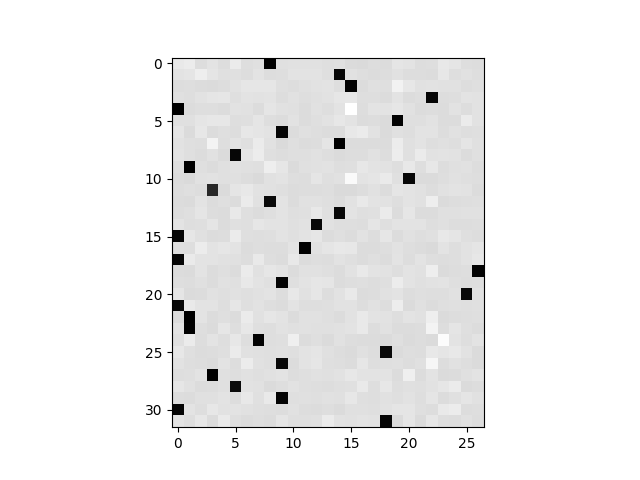

In [86]:
plt.imshow(dlogits.detach(), cmap="gray")
plt.show();

Here, we are visualizing the `dlogits` tensor that contains $32$ examples and $27$ characters per example. What is `dlogits` intuitively? `dlogits` is the softmax/probabilities matrix of the forward pass! The black squares are the positions of the correct indices where we subtracted a `1`. So what does this mean? Let's look at the values of the first row:

In [87]:
F.softmax(logits, 1)[0]

tensor([0.0731, 0.0872, 0.0182, 0.0518, 0.0192, 0.0845, 0.0231, 0.0355, 0.0173,
        0.0319, 0.0364, 0.0370, 0.0371, 0.0285, 0.0345, 0.0132, 0.0085, 0.0190,
        0.0148, 0.0545, 0.0513, 0.0209, 0.0247, 0.0721, 0.0584, 0.0259, 0.0215],
       grad_fn=<SelectBackward0>)

So these are the probabilities of the first row. Whereas:

In [88]:
dlogits[0] * batch_size

tensor([ 0.0731,  0.0872,  0.0182,  0.0518,  0.0192,  0.0845,  0.0231,  0.0355,
        -0.9827,  0.0319,  0.0364,  0.0370,  0.0371,  0.0285,  0.0345,  0.0132,
         0.0085,  0.0190,  0.0148,  0.0545,  0.0513,  0.0209,  0.0247,  0.0721,
         0.0584,  0.0259,  0.0215], grad_fn=<MulBackward0>)

gives us the derivatives. Which is exactly equal to the probabilities, except that the value at the position of the correct index which has the probability value `p - 1`! Also if we sum `dlogits` of this row, we find out they sum to `0` (or at least very close to it):

In [89]:
dlogits[0].sum()

tensor(1.3970e-09, grad_fn=<SumBackward0>)

We can think of the gradients of each row here as a *force* that pulls down on the probabilities of the incorrect characters and pulls up the probability at the correct (black dotted) index. And that's what's basically happening in each row. And the amount of push and pull is exactly equalized because the sum is $0$. So the amount to which we pull down in the probabilities and the amount that we push up on the probability of the correct character is equal. So the repulsion and the attraction are equal. So you can think of the **nn** now as a massive pulley system, or something like that, in which at the level of `dlogits` we're pulling down the probabilities of incorrect and pulling up the probability of the correct ones. And in this complicated pulley system, we think of it as sort of like this tension translating to this complicating pulley mechanism and then eventually we get a tug on the weights and the biases. And basically in each update we just kind of like tug in the direction that we'd like for each of these elements and the parameters are slowly given in to the tug and that's what training the **nn** kind of looks like on a high level. And so the forces of push and pull in these gradients (e.g. see the values of `dlogits[0] * batch_size`) are actually very intuitive here we're pushing and pulling on the correct answer and the amount of force that we're applying is actually proportional to the probabilities that came out in the forward pass. And so for example if our probabilities came out exactly correct, so they would have had zero everywhere except for one at the correct position then the `dlogits` would be all a row of zeros for that example: there would be no push and pull. So the amount to which your prediction is incorrect is exactly the amount by which you're going to get a pull or a push in that dimension. So if you have for example a very confidently mispredicted element, then what's going to happen is that element is going to be pulled down very heavily and the correct answer is going to be pulled up to the same amount and the other characters are not going to be influenced too much. So the amount to which you mispredict is then proportional to the strength of the pull and that's happening independently in all the dimensions of this tensor and it's sort of very intuitive and very easy to think through and that's basically the magic of the cross entropy loss and what it's doing dynamically in the backward pass of the **nn**.

## Exercise 3: **backprop** through **batchnorm** but all in one go

We now get to exercise number three, which is a very fun exercise depending on your definition of fun. We are going to do for **batchnorm** exactly what we did for cross entropy **loss** in exercise 2. That is that is we are going to consider it as a glued single mathematical expression and **backprop** through it in a very efficient manner because we are going to derive a much simpler formula for the backward pass of **batchnorm** and we're going to do that using pen and paper. So previously we've broken up **batchnorm** into all of the little intermediate pieces and all the atomic operations inside it and then we **backprop**agated through it one by one. Now, we just have a single forward pass and it's all glued together:

In [90]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = (
    bngain
    * (hprebn - hprebn.mean(0, keepdim=True))
    / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5)
    + bnbias
)
print("max diff:", (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


And we see that we get the exact same result as before: an almost-zero difference. Now for the backward pass, we'd like to also implement a single formula basically for backpropagating through this entire operation that is the **batchnorm**. So in the forward pass previously we took `hprebn`, the hidden states of the pre batch normalization and created `hpreact` which is the hidden states just before the activation. In the **batchnorm** paper:

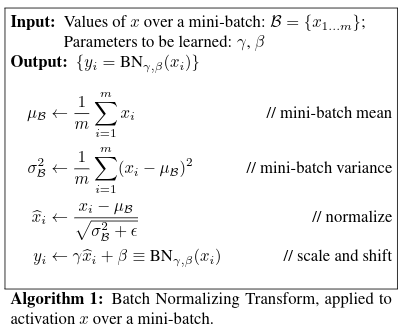

In [91]:
from IPython.display import Image, display

display(Image(filename="batchnorm_algorithm1.png"))

`hprebn` is $x$ and `hpreact` is $y$. So in the backward pass what we'd like to do now is we have `dhpreact` and we'd like to produce `dhprebn` and we'd like to do that in a very efficient manner. So that's the name of the game. Calculate `dhprebn` given `dhpreact` and for the purposes of this exercise, we're going to ignore `gamma` and `beta` and their derivatives, because they take on a very simple form in a very similar way to what we did up above. So let's calculate `dhprebn` ($\dfrac{\partial L}{\partial x_i}$) given `dhpreact` ($\dfrac{\partial L}{\partial y_i}$) (i.e. **backprop** through the **batchnorm**). According to **Algorithm 1** above (from the paper): 


```ascii
       ____μ______(3)_______
      ╱     ╲               │     
    (4)      ╲              │
    ╱         ╲             ↓  
  [x]---→σ²---(2)---→[x̂]---(1)-----→[y]
    ╲                       ↑       ╱│
     ╲______________________│      γ β        
```

the bracketed variables represent vectors and the numbering represents the order in which we are going to **backprop**, going from `(1)` (right) all the way to `(4)` (left). Therefore, given $\dfrac{\partial L}{\partial y_i}$ we want to calculate $\dfrac{\partial L}{\partial x_i}$:

**1**. $\dfrac{\partial L}{\partial \hat{x}_i} = \gamma \dfrac{\partial L}{\partial y_i}$, easy enough :)

**2**. $\dfrac{\partial L}{\partial \sigma^2} = \sum_i \dfrac{\partial L}{\partial \hat{x}_i} \dfrac{\partial \hat{x}_i}{\partial \sigma^2}$, we sum the product of the local and global derivative because $\sigma^2$ feeds into each $\hat{x}_i$ of the $\hat{x}$ vector (so basically there are $m$ (`batch_size`, e.g. $32$) number of arrows feeding from $\hat{x}$ back into $\sigma^2$)

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ = \gamma \sum_i \dfrac{\partial L}{\partial y_i} \dfrac{\partial}{\partial \sigma^2} \left[ ( x_i - \mu ) (\sigma^2 + \epsilon)^{-1/2} \right]$

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ = -\dfrac{\gamma}{2} \sum_i \dfrac{\partial L}{\partial y_i} ( x_i - \mu ) (\sigma^2 + \epsilon)^{-3/2}$

**3**. $\dfrac{\partial L}{\partial \mu} = \sum_i \dfrac{\partial L}{\partial \hat{x}_i} \dfrac{\partial \hat{x}_i}{\partial \mu} + \dfrac{\partial L}{\partial \sigma^2} \dfrac{\partial \sigma^2}{\partial \mu}$, here we also add a second component because as you can see above there are two branches emerging from $\mu$, one into $\sigma^2$ and one into $\hat{x}$. To keep it simple, let's solve each partial derivative separately:

- $\dfrac{\partial \hat{x}_i}{\partial \mu} = \dfrac{\partial}{\partial \mu} \left[ ( x_i - \mu )(\sigma^2 + \epsilon)^{-1/2} \right] = -(\sigma^2 + \epsilon)^{-1/2}$

- $\dfrac{\partial \sigma^2}{\partial \mu} = \dfrac{\partial}{\partial \mu}\left[\dfrac{1}{m - 1}\sum_{i=1}^{m} (x_i - \mu)^2 \right]$, notice $\dfrac{1}{m - 1}$ which is Bessel's correction

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ = \dfrac{-2}{m - 1}\sum_{i=1}^{m} (x_i - \mu)$

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ = \dfrac{-2}{m - 1}(\sum_{i=1}^{m}x_i - \sum_{i=1}^{m}\mu)$

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ = \dfrac{-2}{m - 1}(m\mu - m\mu)$

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ = 0$, **WHOA** :)!

Therefore: $\dfrac{\partial L}{\partial \mu} = \sum_i \dfrac{\partial L}{\partial \hat{x}_i} [-(\sigma^2 + \epsilon)^{-1/2}] + \dfrac{\partial L}{\partial \sigma^2} \cdot 0$

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = -\gamma\sum_i\dfrac{\partial L}{\partial y_i} (\sigma^2 + \epsilon)^{-1/2}$

**4**. $\dfrac{\partial L}{\partial x_i} = \dfrac{\partial L}{\partial \hat{x}_i}\dfrac{\partial \hat{x}_i}{\partial x_i} + \dfrac{\partial L}{\partial \mu}\dfrac{\partial \mu}{\partial x_i} + \dfrac{\partial L}{\partial \sigma^2}\dfrac{\partial \sigma^2}{\partial x_i}$, three components (partial derivative products), one for every path exiting reaching `x` from `L` (one through $\hat{x}$, one through $\mu$ and one through $\sigma^2$). Similarly, let's solve each partial derivative that we do not yet know separately:

- $\dfrac{\partial \hat{x}_i}{\partial x_i} = \dfrac{\partial}{\partial x_i} \left[ ( x_i - \mu )(\sigma^2 + \epsilon)^{-1/2} \right] = (\sigma^2 + \epsilon)^{-1/2}$

- $\dfrac{\partial \mu}{\partial x_i} = \dfrac{\partial}{\partial x_i}\left(\dfrac{1}{m}\sum_j x_j\right) = \dfrac{1}{m}$

- $\dfrac{\partial \sigma^2}{\partial x_i} = \dfrac{\partial }{\partial x_i}\left[\dfrac{1}{m - 1}\sum_j (x_j - \mu)^2 \right] = \dfrac{2}{m - 1} (x_i - \mu)$

Now that we have all the individual derivatives, let's find the three derivative products, one by one:

- $\dfrac{\partial L}{\partial \hat{x}_i}\dfrac{\partial \hat{x}_i}{\partial x_i} = (\sigma^2 + \epsilon)^{-1/2} \gamma \dfrac{\partial L}{\partial y_i}$

- $\dfrac{\partial L}{\partial \mu}\dfrac{\partial \mu}{\partial x_i} = -\gamma\sum_j\dfrac{\partial L}{\partial y_j} (\sigma^2 + \epsilon)^{-1/2} \dfrac{1}{m}$

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = -(\sigma^2 + \epsilon)^{-1/2}\dfrac{\gamma}{m}\sum_j\dfrac{\partial L}{\partial y_j}$

- $\dfrac{\partial L}{\partial \sigma^2}\dfrac{\partial \sigma^2}{\partial x_i} = \left[-\dfrac{\gamma}{2} \sum_j \dfrac{\partial L}{\partial y_j} ( x_j - \mu ) (\sigma^2 + \epsilon)^{-3/2}\right] \left[\dfrac{2}{m - 1} (x_i - \mu)\right]$

$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = (\sigma^2 + \epsilon)^{-1/2}\left[-\gamma \sum_j \dfrac{\partial L}{\partial y_j} ( x_j - \mu ) (\sigma^2 + \epsilon)^{-1/2}\right] \left[\dfrac{1}{m - 1} (x_i - \mu)(\sigma^2 + \epsilon)^{-1/2}\right]$

$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = (\sigma^2 + \epsilon)^{-1/2}\left[-\gamma \sum_j \dfrac{\partial L}{\partial y_j} \dfrac{x_j - \mu}{\sqrt{\sigma^2 + \epsilon}}\right] \left[\dfrac{1}{m - 1} \dfrac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}\right]$

$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = (\sigma^2 + \epsilon)^{-1/2}\left[-\gamma \sum_j \dfrac{\partial L}{\partial y_j} \hat{x}_j \right] \left[\dfrac{1}{m - 1} \hat{x}_i\right]$

And finally, let's add up all the product terms to get the final expression for

$\dfrac{\partial L}{\partial x_i} = (\sigma^2 + \epsilon)^{-1/2} \gamma \dfrac{\partial L}{\partial y_i} - (\sigma^2 + \epsilon)^{-1/2}\dfrac{\gamma}{m}\sum_j\dfrac{\partial L}{\partial y_j} + (\sigma^2 + \epsilon)^{-1/2}\left(-\gamma \sum_j \dfrac{\partial L}{\partial y_j} \hat{x}_j \right) \left(\dfrac{1}{m - 1} \hat{x}_i\right)$

$ \ \ \ \ \ \ \ =  \dfrac{\gamma}{m}(\sigma^2 + \epsilon)^{-1/2} \left( m\dfrac{\partial L}{\partial y_i} - \sum_j\dfrac{\partial L}{\partial y_j} - \dfrac{m}{m - 1} \hat{x}_i \sum_j \dfrac{\partial L}{\partial y_j} \hat{x}_j \right)$

And what we end up with at the end is a fairly simple mathematical expression over here that we cannot simplify further. But basically you'll notice that it only uses the stuff we have ($\dfrac{\partial L}{\partial y_i}$, $\hat{x}_i$) and it gives us the thing we need ($\dfrac{\partial L}{\partial x_i}$). Let's now implement this final result:

In [92]:
dhprebn = (
    bngain
    / batch_size
    * bnvar_inv
    * (
        batch_size * dhpreact
        - dhpreact.sum(0)
        - batch_size / (batch_size - 1) * bnraw * (dhpreact * bnraw).sum(0)
    )
)
cmp("hprebn", dhprebn, hprebn)  # we can only get approximate correctness ~9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [93]:
hprebn.shape, dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(
    0
).shape

(torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

Remember the mathematical expression we analytically calculated applies only to one neuron, whereas the programmatical `dhprebn` expression applies to all the `batch_size` number of neurons we have, in parallel. This is non-trivial, so take your time to see how it is written out with the  broadcasting happening appropriately, so that the shapes work out.

## Exercise 4: training the **mlp** with our own manual backward pass

For the final exercise 4, we want to put it all together. Meaning, we want to train the **mlp** with our own manual backward pass. So first, let's define a new, simpler forward pass function, a manual backward pass function, a training function and a function to print the loss:

In [94]:
def forward(xb, yb):
    emb = C[xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    # Linear layer
    hprebn = embcat @ w1 + b1  # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True)
    bnvar_inv = (bnvar + 1e-5) ** -0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ w2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function
    return emb, embcat, bnvar_inv, bnraw, h, hpreact, logits, loss

In [95]:
def manual_backward(
    parameters,
    logits,
    batch_size,
    xb,
    yb,
    h,
    hpreact,
    bnraw,
    bngain,
    bnvar_inv,
    embcat,
    emb,
):
    dlogits = F.softmax(logits, 1)
    dlogits[range(batch_size), yb] -= 1
    dlogits /= batch_size
    # 2nd layer backprop
    dh = dlogits @ w2.T
    dw2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = (
        bngain
        / batch_size
        * bnvar_inv
        * (
            batch_size * dhpreact
            - dhpreact.sum(0)
            - batch_size / (batch_size - 1) * bnraw * (dhpreact * bnraw).sum(0)
        )
    )
    # 1st layer
    dembcat = dhprebn @ w1.T
    dw1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    dC.index_add_(0, xb.flatten(), demb.view(-1, 10))
    grads = [dC, dw1, db1, dw2, db2, dbngain, dbnbias]
    return grads

In [96]:
def train(
    x,
    y,
    parameters,
    maxsteps=200000,
    batchsize=32,
    initial_lr=0.1,
    run_torch_backward=False,
    break_at_step=None,
):
    lossi = []
    # use this context manager to enable or disable gradient tracking
    with torch.set_grad_enabled(run_torch_backward):
        # kick off optimization
        for i in range(maxsteps):
            xb, yb = construct_minibatch()
            emb, embcat, bnvar_inv, bnraw, h, hpreact, logits, loss = forward(xb, yb)
            for p in parameters:
                p.grad = None
            if run_torch_backward:
                for t in [emb, embcat, bnvar_inv, bnraw, h, hpreact, logits]:
                    t.retain_grad()
                loss.backward()
            grads = manual_backward(
                parameters=parameters,
                batch_size=batch_size,
                xb=xb,
                yb=yb,
                logits=logits,
                h=h,
                hpreact=hpreact,
                bnraw=bnraw,
                bngain=bngain,
                bnvar_inv=bnvar_inv,
                embcat=embcat,
                emb=emb,
            )
            # update
            lr = (
                initial_lr if i < 100000 else initial_lr / 10
            )  # step learning rate decay
            for p, grad in zip(parameters, grads):
                p.data += -lr * (p.grad if run_torch_backward else grad)
            # track stats
            if i % 10000 == 0:  # print every once in a while
                print(f"{i:7d}/{maxsteps:7d}: {loss.item():.4f}")
            lossi.append(loss.log10().item())
            if break_at_step is not None and i >= break_at_step:
                break
    return grads, lossi

In [97]:
@torch.no_grad()  # this decorator disables gradient tracking
def print_loss(x, y, prefix=""):
    loss = forward(x, y)[-1]
    print(f"{prefix} {loss}")
    return loss

Cool. Now, we will simply train our **nn** using the backprop expressions we calculated manually (`manual_backward()`) instead of having PyTorch do it for us (i.e. `loss.backward()`). Basically, we have plucked out all the operations that PyTorch would calculate and we have instead implemented them manually. Of course, our manual results are identical to the automated ones, as we have verified already. So, let's train and do both classic PyTorch backpropagation and our manual propagation and break the training loop at $100$ epochs and check whether gradients match the PyTorch ones:

In [98]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass
parameters = define_nn(n_hidden=200, n_embd=10)
grads, lossi = train(
    xtrain, ytrain, parameters, run_torch_backward=True, break_at_step=100
)
# check gradients against PyTorch
for p, g in zip(parameters, grads):
    cmp(str(tuple(p.shape)), g, p)

12297
      0/ 200000: 3.8279
(27, 10)        | exact: False | approximate: True  | maxdiff: 9.313225746154785e-09
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.916241884231567e-09
(200,)          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 2.2351741790771484e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 1.979060471057892e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


So here we see that our gradients are mostly, but not exactly, equal. Most are approximately equal with only tiny differences of the `e-9` magnitude. Which is totally fine. Can you figure out why we don't get exact correctness for all the gradients? If we now redefine our **nn** and train without breaking and only do our manual **backprop** (feels amazing to realize we don't need the automatic backward pass anymore!):

In [99]:
parameters = define_nn(n_hidden=200, n_embd=10)
grads, lossi = train(xtrain, ytrain, parameters)

12297
      0/ 200000: 3.8279
  10000/ 200000: 2.1609
  20000/ 200000: 2.4227
  30000/ 200000: 2.4362
  40000/ 200000: 2.0088
  50000/ 200000: 2.4084
  60000/ 200000: 2.4508
  70000/ 200000: 2.1090
  80000/ 200000: 2.3592
  90000/ 200000: 2.2353
 100000/ 200000: 1.9750
 110000/ 200000: 2.3438
 120000/ 200000: 2.0156
 130000/ 200000: 2.4772
 140000/ 200000: 2.3107
 150000/ 200000: 2.1108
 160000/ 200000: 1.9497
 170000/ 200000: 1.8004
 180000/ 200000: 2.0284
 190000/ 200000: 1.8848


After training, we will calibrate the **batchnorm** parameters as we did not keep track of the running mean and variance in the training loop:

In [100]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[xtrain]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

And print both the training and validation losses:

In [101]:
print_loss(xtrain, ytrain, prefix="train")
print_loss(xval, yval, prefix="val");

train 2.0673816204071045
val 2.1060986518859863


We achieve a pretty good loss, very similar to what we achieved in our previous lecture! Now, all that remains is to sample from our model:

In [102]:
# sample from the model
g = torch.Generator().manual_seed(SEED + 10)
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
        hpreact = embcat @ w1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
        h = torch.tanh(hpreact)  # (N, n_hidden)
        logits = h @ w2 + b2  # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itoc[i] for i in out))

mora.
mayah.
see.
mad.
ryla.
ren.
ruthadraegen.
chedielin.
shi.
jenleigh.
sananaraelyn.
malaia.
noshubergihirael.
kindreth.
konnie.
cayu.
zayven.
jamyleyeh.
yuma.
myston.


And we see the sort of name-like gibberish that we have been used to. Which of course means that the model works, as before 😃!

## Summary

Everything is the same except that we didn't use `loss.backward()` or [`torch.autograd`](https://pytorch.org/docs/stable/autograd.html#) and we estimated the gradients ourselves, by hand. And so hopefully you're looking at the the manual backward pass we did through this **nn** and you're thinking to yourself "actually that's not too complicated". Each one of these layers is like three lines of code or something like that and most of it is fairly straightforward potentially with the notable exception of the **batchnorm** backward pass. And that's everything we wanted to cover in this lecture. So hopefully you found this interesting and what is noteworthy about it honestly is that it gave us a very nice diversity of layers to backpropagate through. It should give us a pretty nice and comprehensive sense of how these backward passes are implemented and how they work and you'd be able to derive them yourself. But of course in practice you probably don't want to: you want to use [`torch.autograd`](https://pytorch.org/docs/stable/autograd.html#) instead. But hopefully now you have some intuition about how gradients flow backwards through the **nn** starting at the **loss** and how they flow through all the variables. And if you understood a good chunk of it and if you now have a sense of that, you should proudly count yourself as one of these buff doges on the left instead of the sorry little one on the right here:

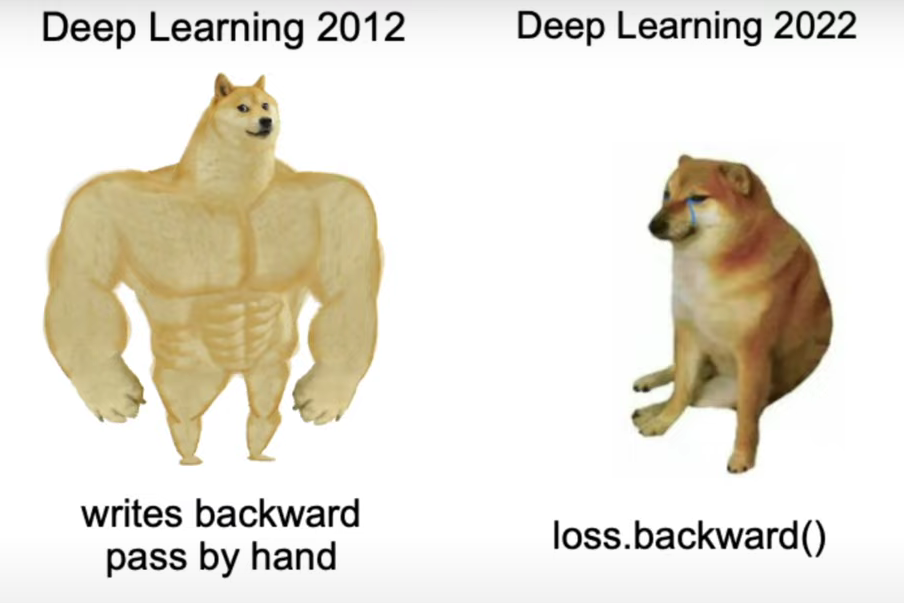

In [103]:
from IPython.display import Image, display

display(Image(filename="backwardmemelol.png"))

## Outro

Now in the next lecture we're actually going to go to LSTMs and all the other variants of RNNs and we're going to start to complexify the architecture and start to achieve better log likelihoods and what not. Now there's something to look forward to! Time for new adventures! See you there.